<h1> Part 1: Preprocessing, graphs, and features </h1>

[Preliminary](#preliminary)<br>
[Preprocessing](#preprocessing)<br>
[Graphical Analysis](#graphical-analysis)<br>
[Feature engineering](#feature-engineering)<br>


# Preliminary

In [1]:
# import libraries
# ================

# for file and foler operations
import os
from glob import glob

# storing and analysing data
import numpy as np
import pandas as pd

# to handle timezone
from dateutil import tz

# for graphs
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# suppress warnings about features that 
# will be deprecated from pandas coming versions
import warnings
warnings.filterwarnings('ignore')

In [2]:
# general settings
# ================

# all files (ensure csv and excel files in RawFiles directory in working directory) - or use absolute path of the data
data_directory = os.path.normpath(os.path.abspath(r'./RawFiles'))


# used to unify timezone information to Melbourne, Australia
melbourne_tz = tz.gettz('Australia/Melbourne')

# better display options
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x if int(x) != x else '%d' % int(x))

# for convenient display of datasets
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

### loading data

In [3]:
# Meters with EV
meters_with_ev_df = pd.read_excel(os.path.join(data_directory, 'EV_training_meters_list.xlsx'))
meters_with_ev_df.head()

Meter_ID EV Make             EV Model  EV wall charger installed?  \
0     14702    Tesla  Model 3 and Model X                        Yes   
1     21463   Nissan                 Leaf                         No   
2     63317  Nissan                  Leaf                         No   
3     69825  Jaguar                 ipace                        Yes   
4     98536   Jaguar                ipace                         No   

  How many kms do you usually drive each year? \n(prior to the COVID-19 pandemic)  
0                                                             Greater than 20,000  
1                                                                 5,000 to 10,000  
2                                                                 5,000 to 10,000  
3                                                                10,000 to 15,000  
4                                                                15,000 to 20,000

In [4]:
# consumption data
consumption_df = pd.concat(
    [pd.read_csv(file, index_col=0)
     for file in glob(f'{data_directory}/consumption*csv')], 
    ignore_index=True,
)
consumption_df.head()

meter_id                          element_uuid    start_timestamptz_ts  \
0    526392  fd99eeea-697a-4d73-afb2-2824c2d8d1d0  2021-04-04 13:00:00+00   
1    526392  fd99eeea-697a-4d73-afb2-2824c2d8d1d0  2021-04-04 13:30:00+00   
2    526392  fd99eeea-697a-4d73-afb2-2824c2d8d1d0  2021-04-04 12:00:00+00   
3    526392  fd99eeea-697a-4d73-afb2-2824c2d8d1d0  2021-04-04 12:30:00+00   
4    526392  fd99eeea-697a-4d73-afb2-2824c2d8d1d0  2021-04-04 11:00:00+00   

   active_consumption_kwh  active_generation_kwh  
0                 0.07500                    NaN  
1                 0.10000                    NaN  
2                 0.13120                    NaN  
3                 0.15000                    NaN  
4                 0.13750                    NaN

In [5]:
# power quality data
power_quality_df = pd.concat(
    [pd.read_csv(file, index_col=0)
     for file in glob(f'{data_directory}/power_quality*csv')],
    ignore_index=True,
)
power_quality_df.head()

meter_id channel_cd                interval_ts  voltage_lvt  amps_lct  \
0    690991          a  2021-04-01 00:00:00+11:00    247.12000   0.73784   
1    690991          a  2021-04-01 00:05:00+11:00    245.97000   1.10632   
2    690991          a  2021-04-01 00:10:00+11:00    245.59000   1.11735   
3    690991          a  2021-04-01 00:15:00+11:00    245.25000   1.10431   
4    690991          a  2021-04-01 00:20:00+11:00    245.52000   1.10231   

   power_factor_pf  number_of_phases overground_or_underground  
0         -0.94600                 1                        OH  
1          0.99700                 1                        OH  
2          0.99700                 1                        OH  
3          0.99700                 1                        OH  
4          0.99700                 1                        OH

# Preprocessing

In [6]:
# simple names for columns
def simple_col_name(col):
    col = col.lower().strip()
    return {'meter_id': 'meter',
            'start_timestamptz_ts': 'time',
            'interval_ts': 'time',
            'active_consumption_kwh': 'consumption',
            'active_generation_kwh': 'generation',
            'ev make': 'make',
            'ev model': 'model',
            "amps_lct": 'amps',
            'ev wall charger installed?': 'charger',
            'how many kms do you usually drive each year? \n(prior to the covid-19 pandemic)': 'drive_km',
            'power_factor_pf': 'power_factor',
            'channel_cd': 'channel',
            'voltage_lvt': 'voltage',
            'number_of_phases': 'phases',
            }.setdefault(col, col)

for df in consumption_df, power_quality_df, meters_with_ev_df:
    df.rename(columns=simple_col_name, inplace=True)


In [7]:
#  consumption dataset
# ====================

# unify time variable (to Melbourne timzone)
consumption_df['time'] = pd.to_datetime(consumption_df['time'], infer_datetime_format=True, utc=True).dt.tz_convert(melbourne_tz)

# total electricity consumption = active consumption + active generation
consumption_df['consumption'] = consumption_df['consumption'] + consumption_df['generation'].fillna(0)
consumption_df.drop('generation', axis=1, inplace=True)

# sum across element_uuid (eliminating it)
consumption_df = consumption_df.groupby(['meter', 'time']).sum().reset_index()

# has_ev equals 1 if matched with known meters with EV, 0 otherwise
meters_with_ev_df['has_ev'] = 1
consumption_df = pd.merge(left=consumption_df, right=meters_with_ev_df, on='meter', how='outer')
consumption_df['has_ev'] = consumption_df['has_ev'].fillna(0).astype('int')

# sort by meter and time
consumption_df.sort_values(['meter', 'time'], inplace=True, ignore_index=True)

# make, model, charger, drive_km - used while interpreting graphs (below)
consumption_df.isna().sum()

meter                 0
time                  0
consumption           0
make           20551483
model          20551483
charger        20551483
drive_km       20551483
has_ev                0
dtype: int64

In [8]:
consumption_df.head()

meter                      time  consumption make model charger drive_km  \
0    396 2020-10-01 10:00:00+10:00      0.11870  NaN   NaN     NaN      NaN   
1    396 2020-10-01 10:30:00+10:00      0.11870  NaN   NaN     NaN      NaN   
2    396 2020-10-01 11:00:00+10:00      0.08120  NaN   NaN     NaN      NaN   
3    396 2020-10-01 11:30:00+10:00      0.09370  NaN   NaN     NaN      NaN   
4    396 2020-10-01 12:00:00+10:00      0.10000  NaN   NaN     NaN      NaN   

   has_ev  
0       0  
1       0  
2       0  
3       0  
4       0

In [9]:
# power quality datasets
# ======================

# drop unnecessary columns
power_quality_df.drop(['overground_or_underground'], axis=1, inplace=True)

# # fixing columns data types (numeric for amps, voltage, phases)
# for col in ['power_factor', 'amps', 'voltage']:
#     power_quality_df[col] = pd.to_numeric(col, 'coerce')

# unify time variable (to Melbourne timzone)
power_quality_df['time'] = pd.to_datetime(power_quality_df['time'], infer_datetime_format=True, utc=True).dt.tz_convert(melbourne_tz)

# eliminating channel 'b' for meters with single phase
power_quality_df = power_quality_df.query("phases == 3 | channel == 'a'")

# absolute power factor (so it does not cancel each other in next step when we take average)
power_quality_df['abs_power_factor'] = power_quality_df['power_factor'].abs()

# downsample the power quality dataset to 30T interval to match with consumption dataset
power_quality_df = power_quality_df.set_index('time').groupby(['meter'])\
    .resample('30min').aggregate(
    {
        "voltage": np.nanmean,
        "amps": np.nanmean,
        "abs_power_factor": np.nanmean,
        "voltage": np.nanmean,
        "phases": "first",
    }).fillna(method='ffill').reset_index()

# sort for consistencty with power consumption dataset
power_quality_df.sort_values(['meter', 'time'], inplace=True, ignore_index=True)
power_quality_df.head()


meter                      time   voltage    amps  abs_power_factor  phases
0    396 2020-10-01 00:00:00+10:00 241.13500 1.14944           0.87300       1
1    396 2020-10-01 00:30:00+10:00 241.52833 1.12468           0.87883       1
2    396 2020-10-01 01:00:00+10:00 242.05500 1.17592           0.88100       1
3    396 2020-10-01 01:30:00+10:00 242.70167 1.05074           0.86717       1
4    396 2020-10-01 02:00:00+10:00 243.04667 0.41902           0.86367       1

### Merging consumption and power quality datasets

In [10]:
# merging consumption with power quality
fulldata = pd.merge(left=consumption_df, right=power_quality_df, on=['meter', 'time'], validate="one_to_one")
fulldata.head()

meter                      time  consumption make model charger drive_km  \
0    396 2020-10-01 10:00:00+10:00      0.11870  NaN   NaN     NaN      NaN   
1    396 2020-10-01 10:30:00+10:00      0.11870  NaN   NaN     NaN      NaN   
2    396 2020-10-01 11:00:00+10:00      0.08120  NaN   NaN     NaN      NaN   
3    396 2020-10-01 11:30:00+10:00      0.09370  NaN   NaN     NaN      NaN   
4    396 2020-10-01 12:00:00+10:00      0.10000  NaN   NaN     NaN      NaN   

   has_ev   voltage    amps  abs_power_factor  phases  
0       0 246.01833 1.25084           0.75650       1  
1       0 250.45667 1.25837           0.80867       1  
2       0 245.60667 0.93605           0.69267       1  
3       0 246.77333 1.01620           0.76617       1  
4       0 242.55000 0.58744           0.85900       1

In [11]:
print(consumption_df.shape)
print(power_quality_df.shape)
print(fulldata.shape)

(21773779, 8)
(21305269, 6)
(21255060, 12)


# Graphical Analysis

Helper functions

In [12]:
df_for_plots = fulldata.copy().set_index(['meter', 'time'])

# min and max date in full dataset
min_date, max_date = df_for_plots.reset_index()['time'][[0, len(df_for_plots) - 1]]

def subset_by_meter(meter_id: int, start: str, end: str, cols: None | list = None):
    """plot cols from cons_for_plots, quality_for_plots; both should be indexed by meter and time. That for specific meter from start to end"""
    # ensure start and end dates are within dataset range
    cols = cols or ['consumption', 'amps']
    start = max(pd.to_datetime(start).tz_localize(melbourne_tz), min_date)
    end = min(pd.to_datetime(end).tz_localize(melbourne_tz), max_date)

    meter_data =  df_for_plots.loc[pd.IndexSlice[meter_id, start:end], cols].droplevel('meter')
    return meter_data


def plot_subplots_common_x(meter_data, hours_interval: int | None = None) -> None:
    """plot meter_data (better call this with output from subset_by_meter)"""
    fig, axes = plt.subplots(2, 1, figsize=(30, 12))
    # plot at a time
    for col, ax in zip(meter_data.columns, axes):
        meter_data[col].plot(ax=ax, subplots=True, x_compat=True)
        ax.set_title(col.title())
        ax.set_xlabel("")
        # X axis labels
        date_locator = mdates.DayLocator(interval=1)
        date_form = mdates.DateFormatter("%m-%d")
        ax.xaxis.grid(True, which='major', color='gray')
        ax.xaxis.set_major_locator(date_locator)
        ax.xaxis.set_major_formatter(date_form)
        ax.tick_params(axis='x', which='major', pad=20)
        if hours_interval is not None:
            hour_locator = mdates.HourLocator(interval=hours_interval)
            hour_form = mdates.DateFormatter("%H")
            ax.xaxis.set_minor_locator(hour_locator)
            ax.xaxis.set_minor_formatter(hour_form)

def plot_consumption_amps(meter, start='2021-11-15', end='2021-11-30', hours_interval=12, verbose=True):
    meter_data = subset_by_meter(meter_id=meter, start=start, end=end)
    if verbose:
        meter_info = meters_with_ev_df[meters_with_ev_df['meter'] == meter]
        if not meter_info.empty:
            print(meter_info)
        else:
            print('meter has no EV')

    
    fig = plot_subplots_common_x(meter_data, hours_interval=hours_interval)


In [13]:
meters_with_ev = meters_with_ev_df['meter'].to_list()
meters_with_no_ev = list(set(fulldata['meter'].unique().tolist()) - set(meters_with_ev))

Consumption and current for meters with EV between 15th and 30th November 2021

   meter   make                model charger             drive_km  has_ev
0  14702  Tesla  Model 3 and Model X     Yes  Greater than 20,000       1


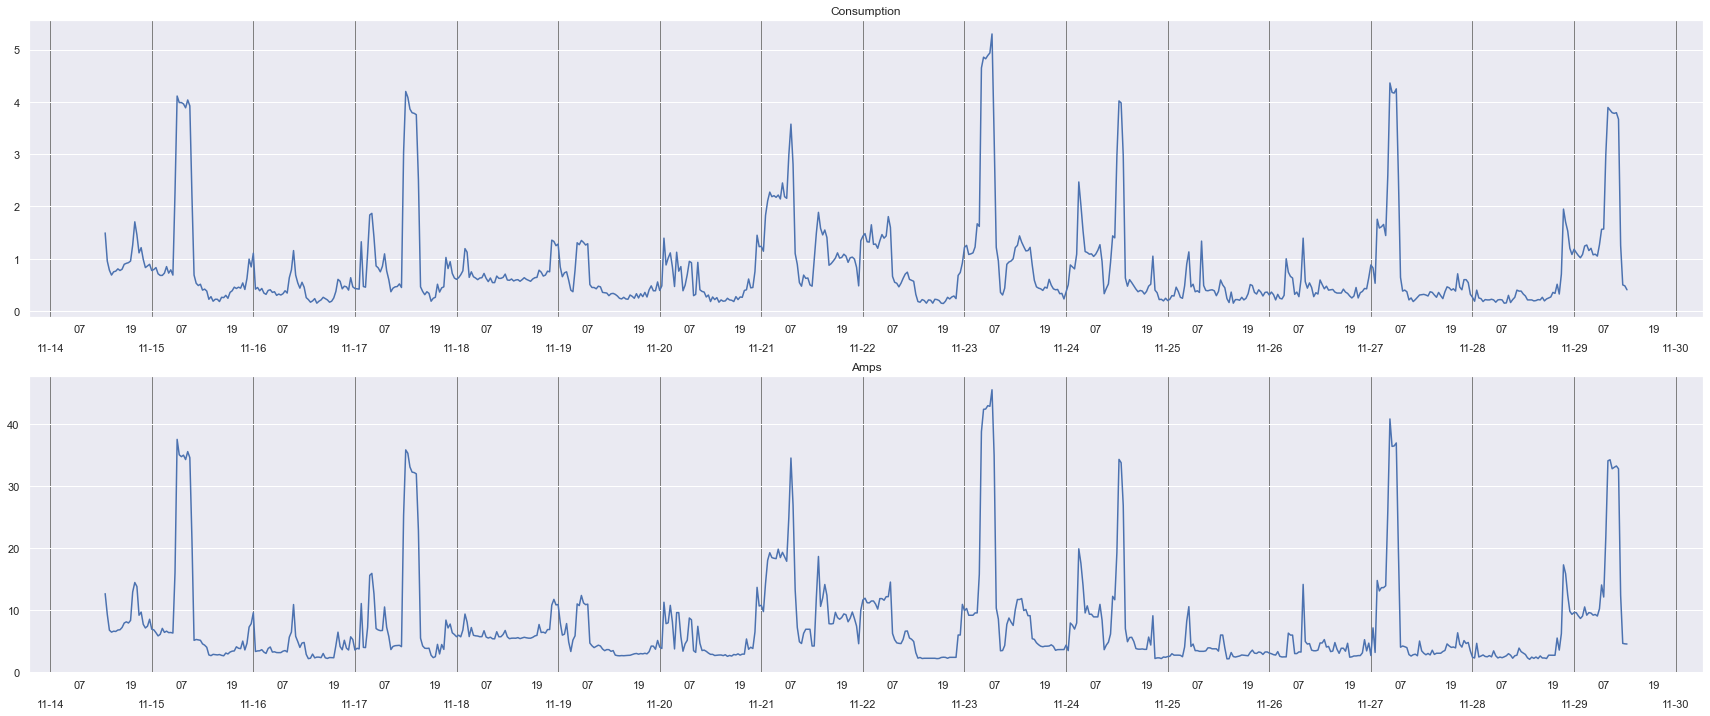

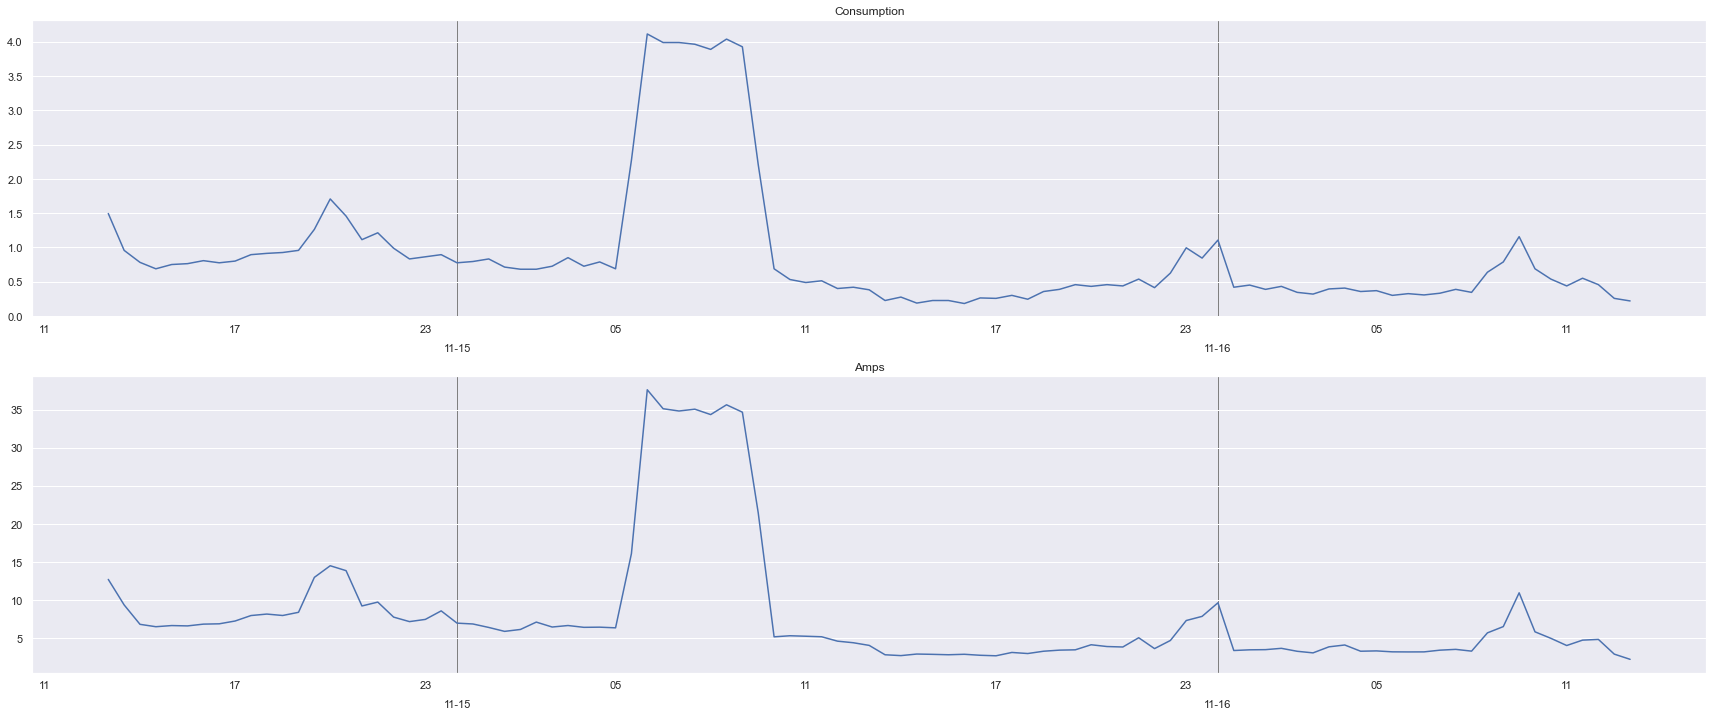

In [14]:
plot_consumption_amps(meter=meters_with_ev[0])
## example of customized plot
plot_consumption_amps(meter=meters_with_ev[0], start='2021-11-15', end='2021-11-17', hours_interval=6, verbose=False)

   meter    make model charger         drive_km  has_ev
1  21463  Nissan  Leaf      No  5,000 to 10,000       1


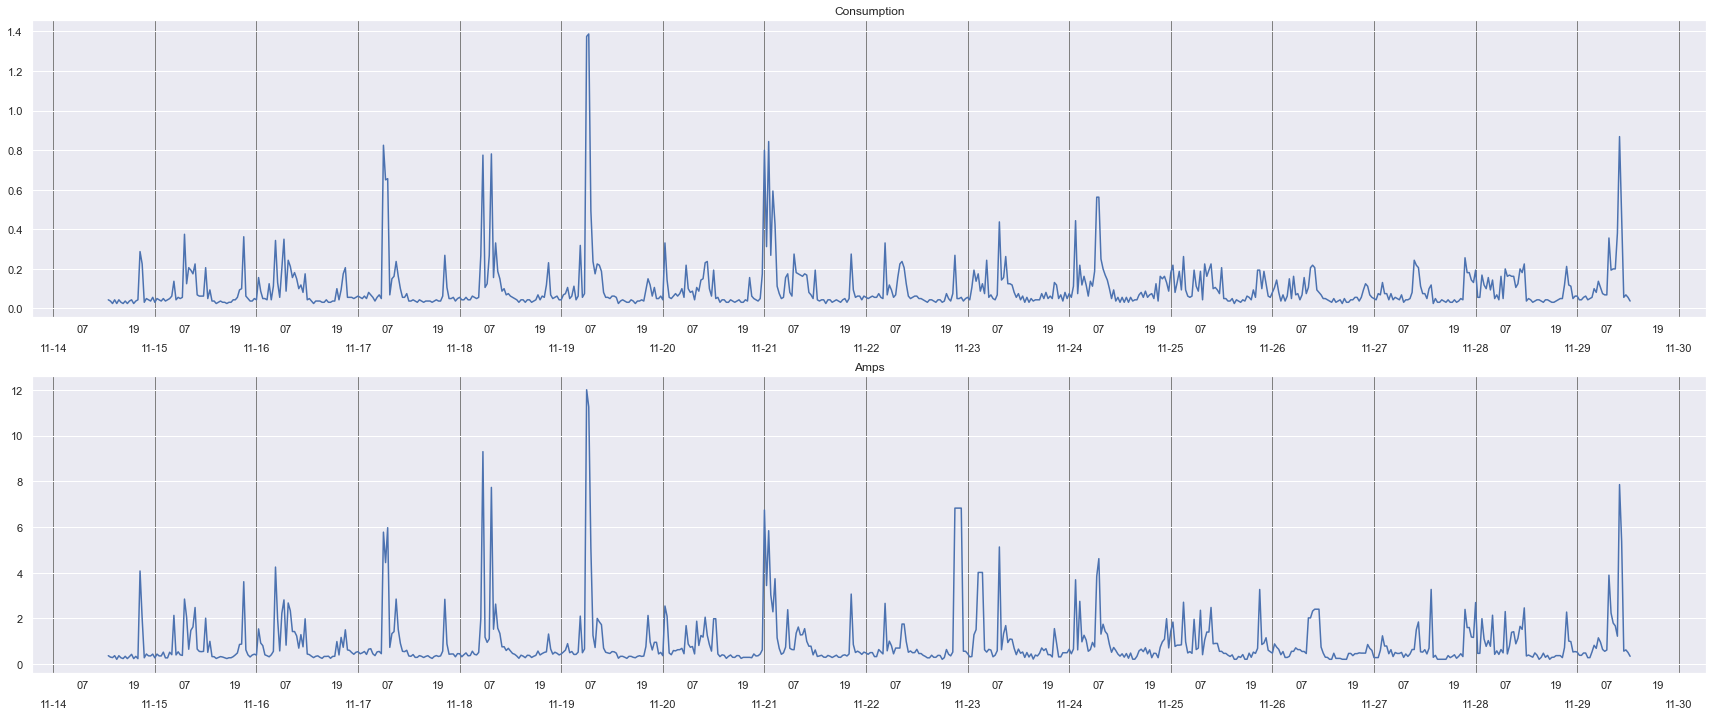

In [15]:
plot_consumption_amps(meter=meters_with_ev[1])

   meter     make model charger         drive_km  has_ev
2  63317  Nissan   Leaf      No  5,000 to 10,000       1


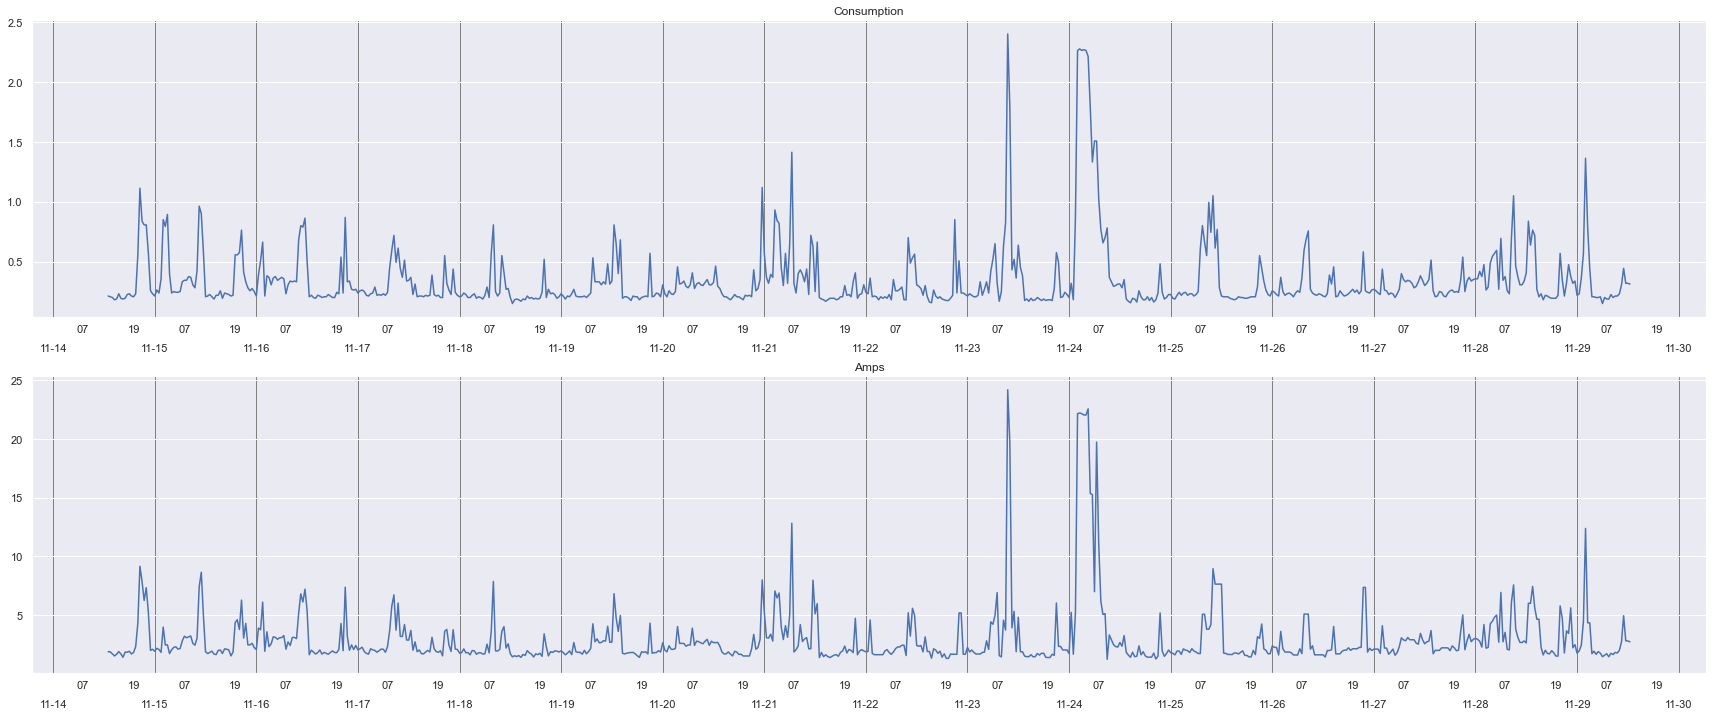

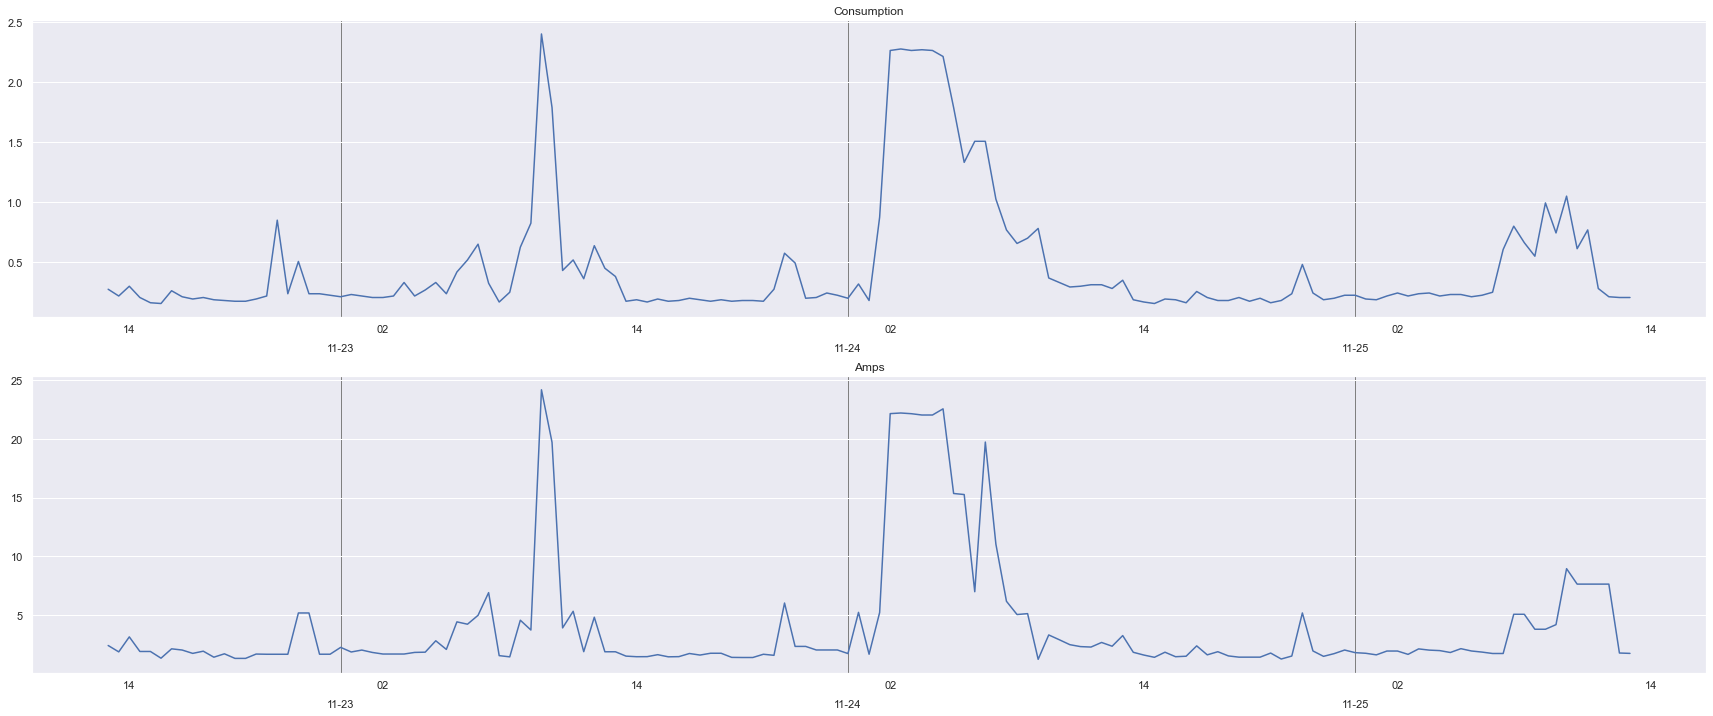

In [16]:
plot_consumption_amps(meters_with_ev[2])
plot_consumption_amps(meters_with_ev[2], start='2021-11-23', end='2021-11-26', verbose=False)

   meter     make  model charger          drive_km  has_ev
3  69825  Jaguar   ipace     Yes  10,000 to 15,000       1


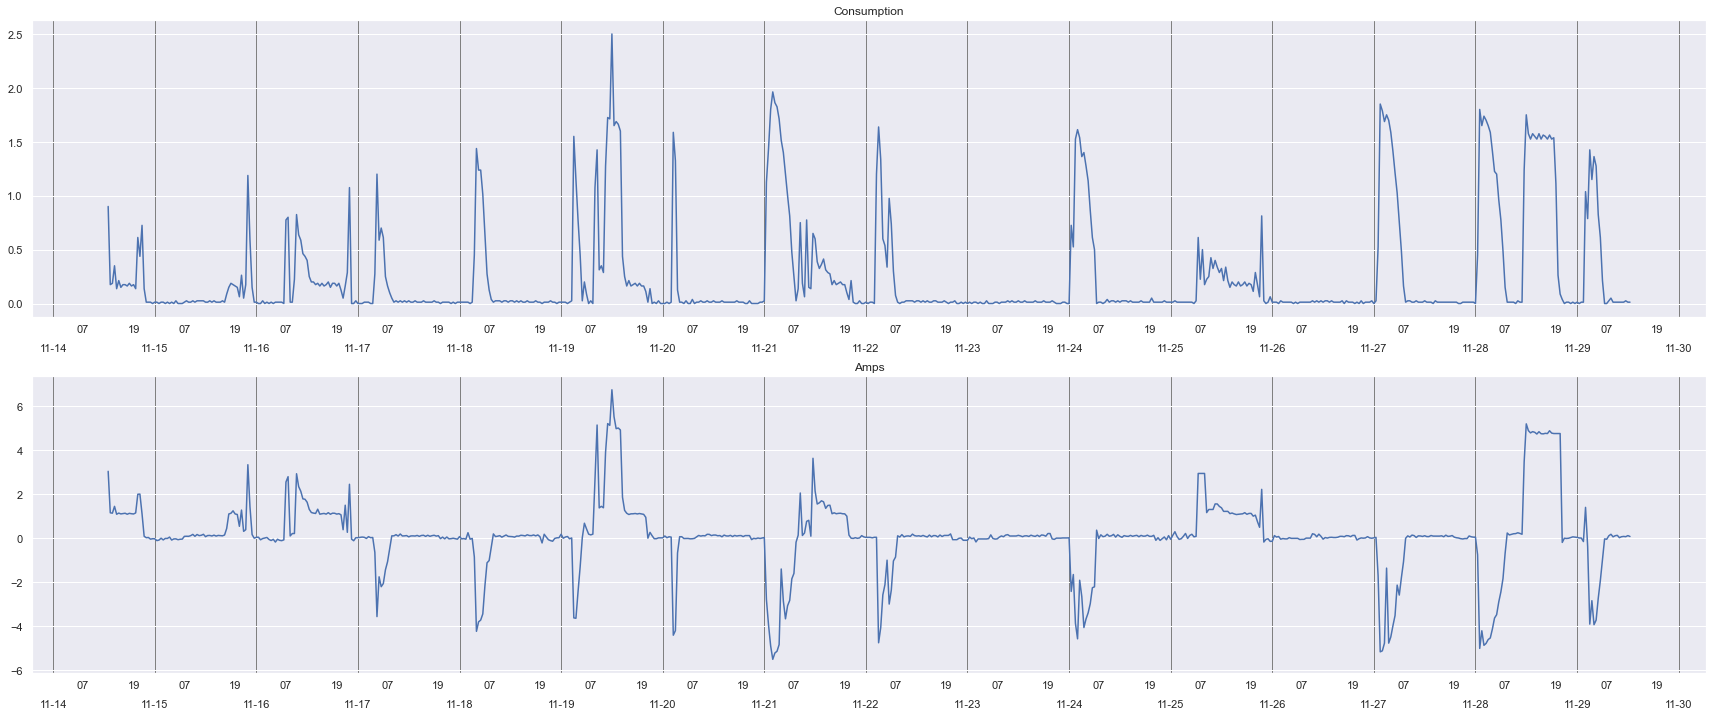

In [17]:

plot_consumption_amps(meters_with_ev[3])

   meter    make  model charger          drive_km  has_ev
4  98536  Jaguar  ipace      No  15,000 to 20,000       1


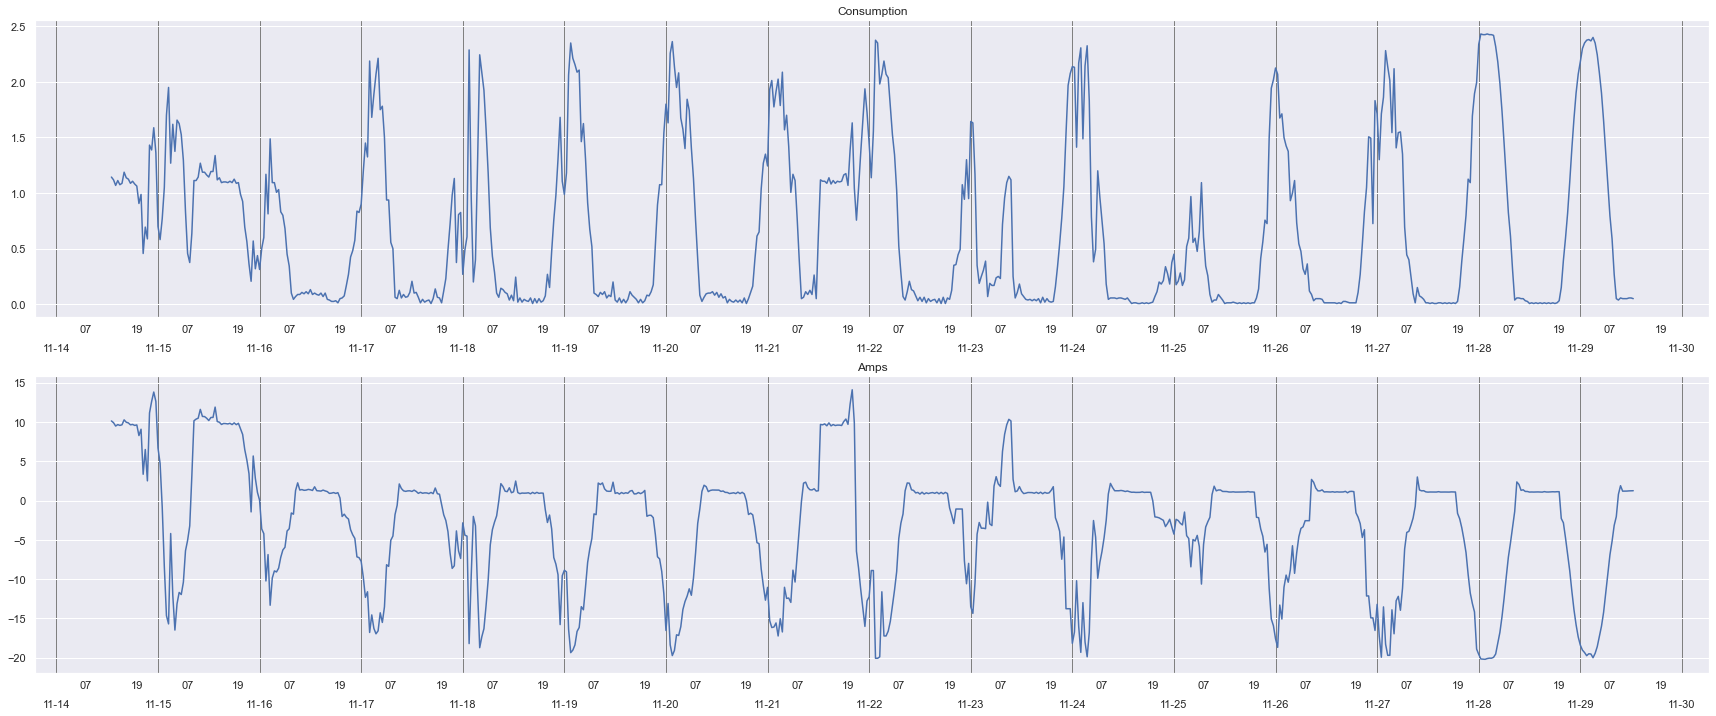

In [18]:
plot_consumption_amps(meters_with_ev[4])

    meter   make             model charger         drive_km  has_ev
5  102145  Tesla  Model S, Model 3     Yes  5,000 to 10,000       1


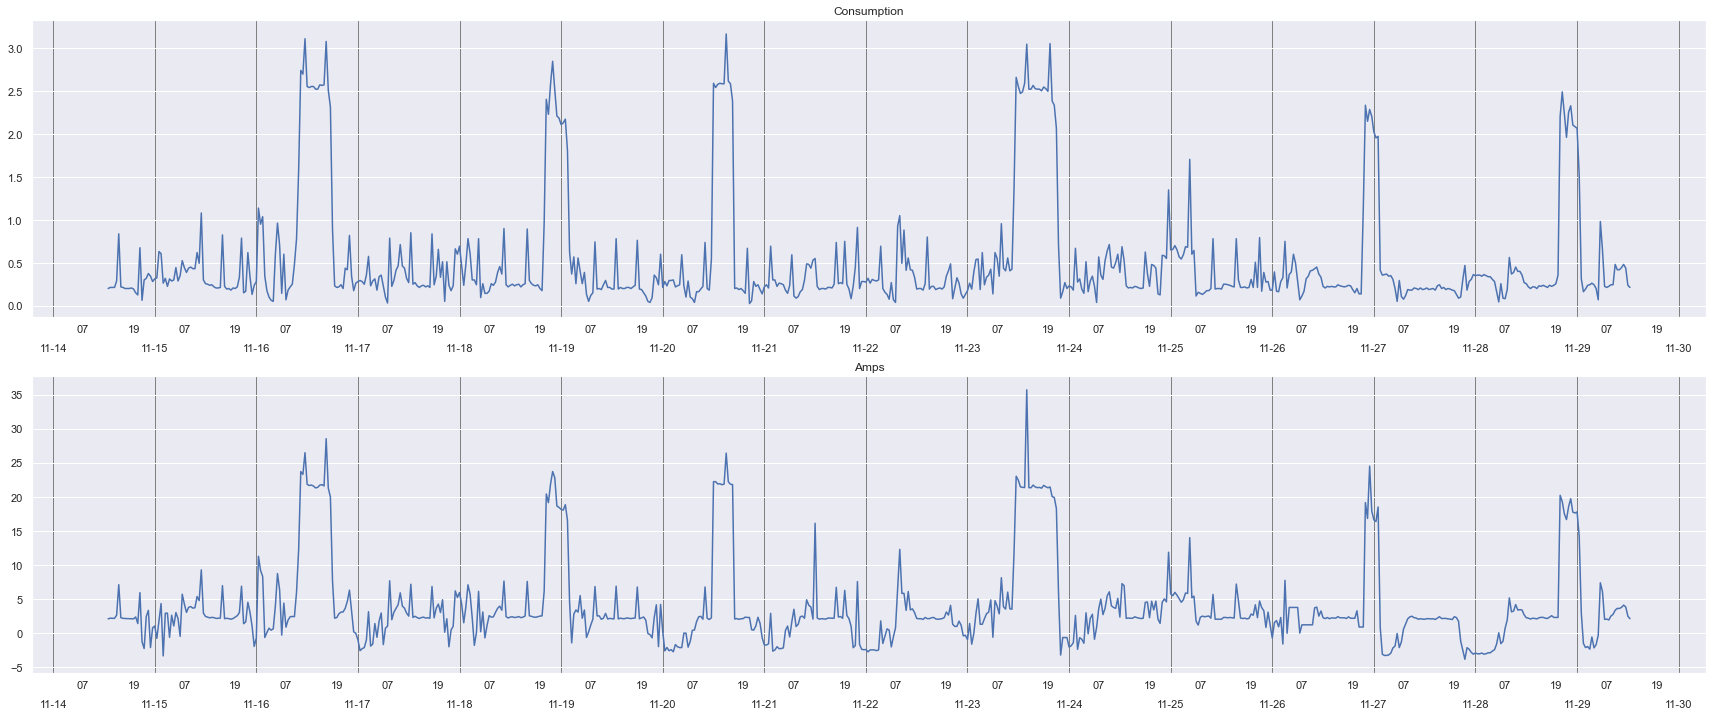

In [19]:
plot_consumption_amps(meters_with_ev[5])

    meter     make  model charger          drive_km  has_ev
6  109154  Hyundai  Ioniq     Yes  10,000 to 15,000       1


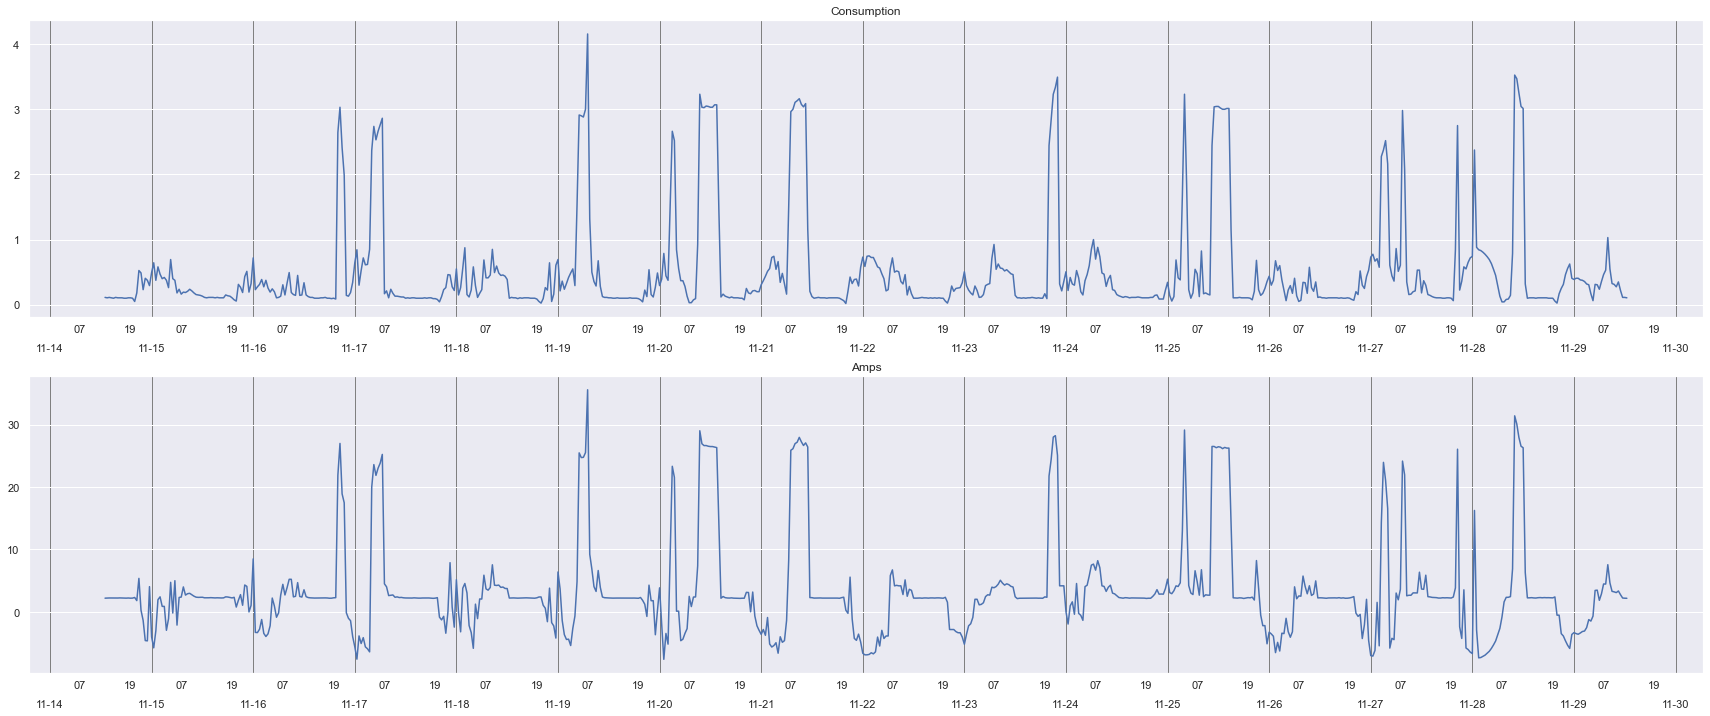

In [20]:
plot_consumption_amps(meters_with_ev[6])

    meter     make   model charger         drive_km  has_ev
7  120889  Renault  Zoe 40     Yes  5,000 to 10,000       1


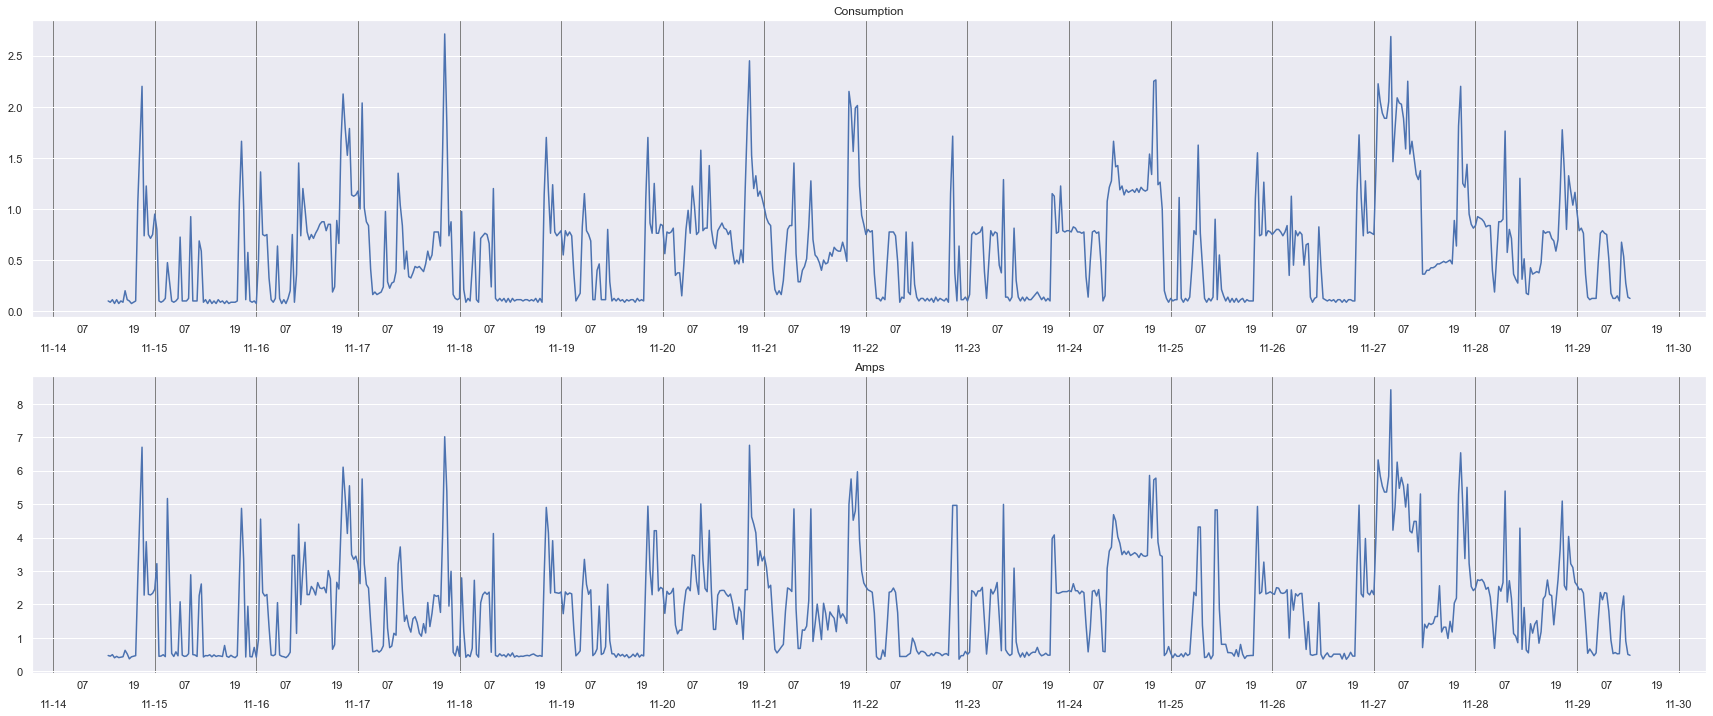

In [21]:
plot_consumption_amps(meters_with_ev[7])

    meter   make    model charger          drive_km  has_ev
8  146262  Tesla  Model 3     Yes  15,000 to 20,000       1


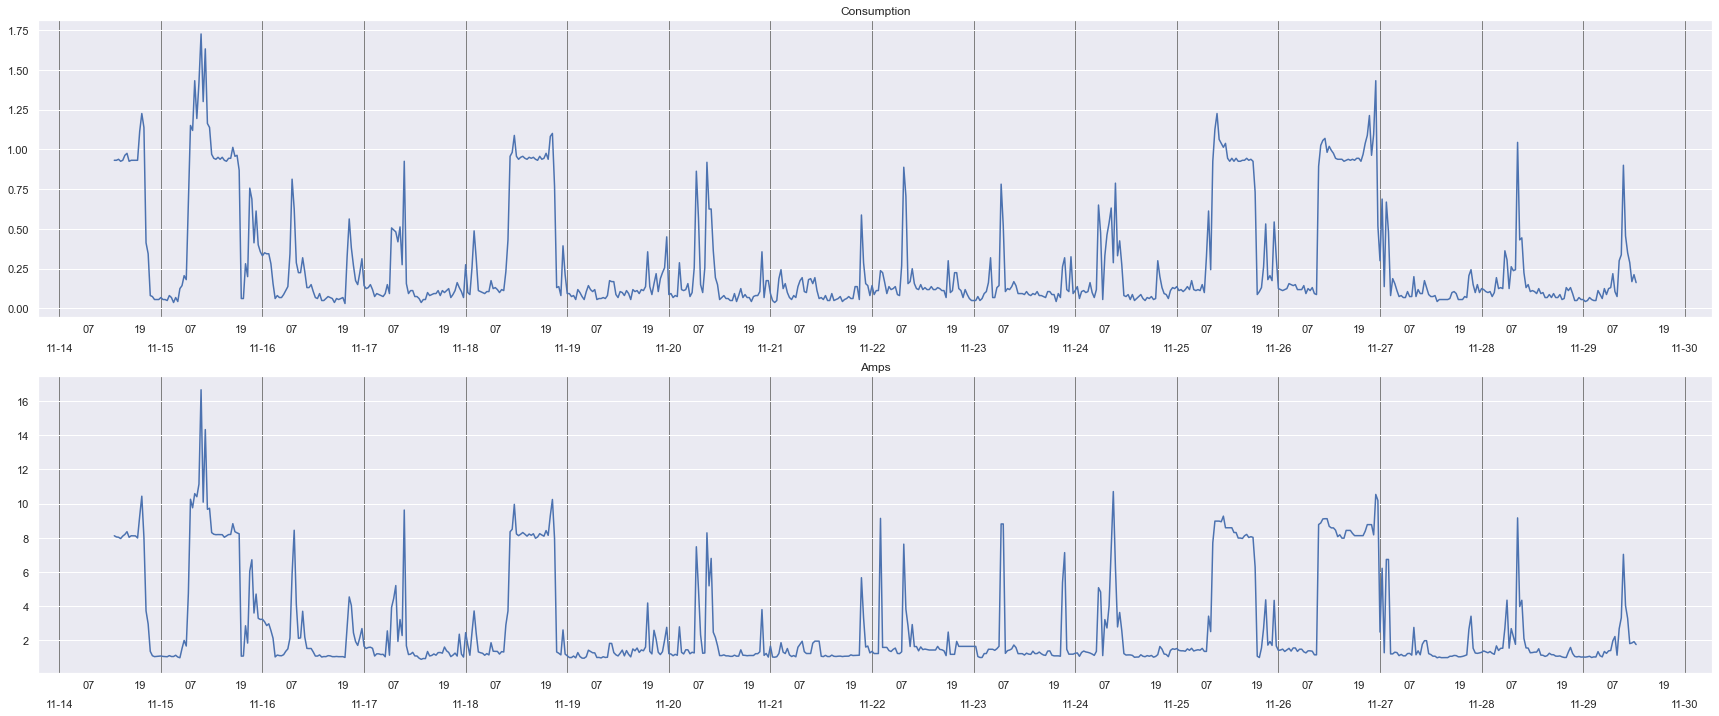

In [22]:
plot_consumption_amps(meters_with_ev[8])

    meter        make      model charger          drive_km  has_ev
9  147369  Mitsubishi  Outlander      No  10,000 to 15,000       1


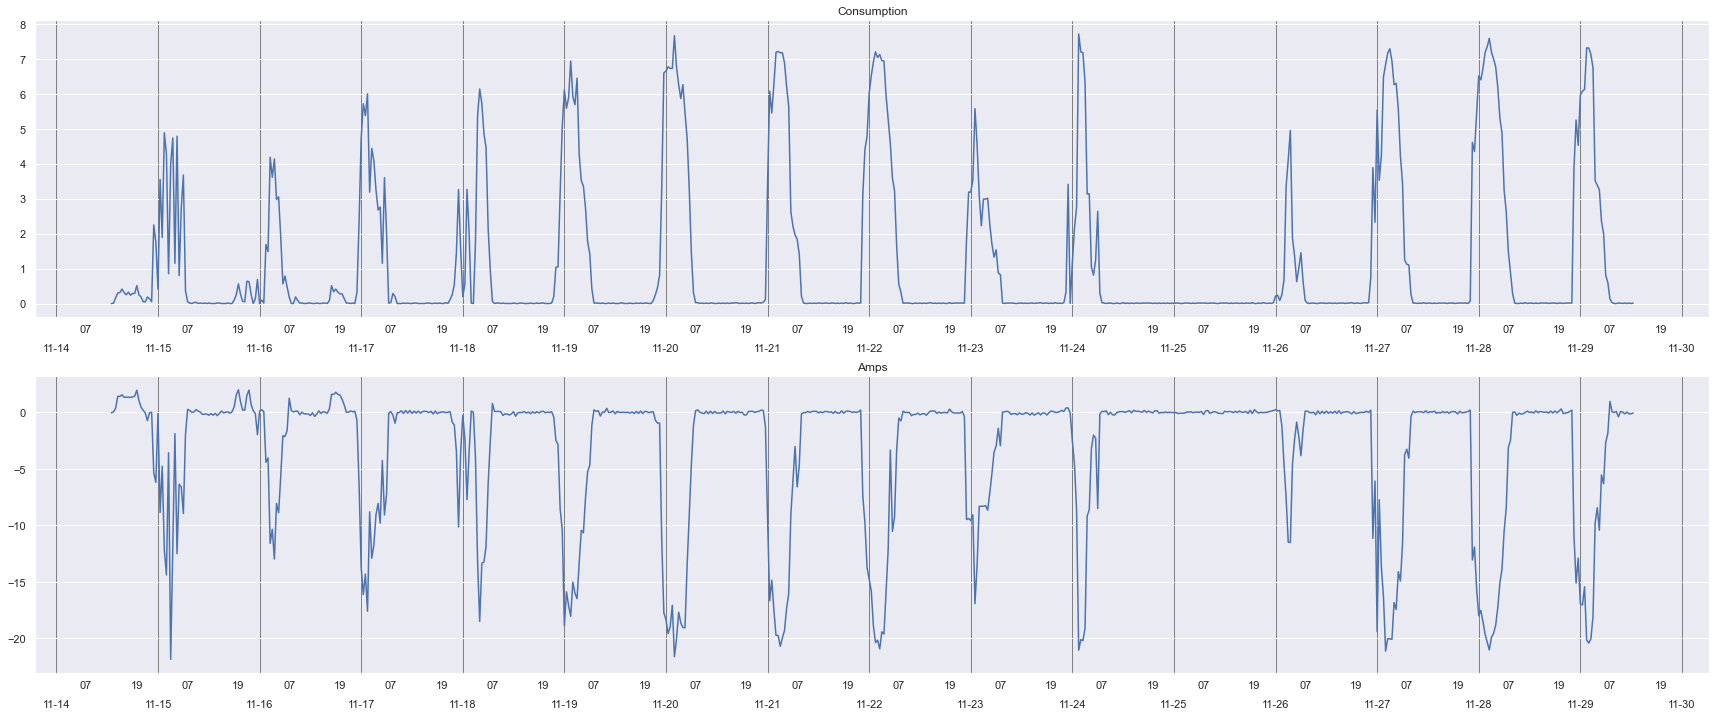

In [23]:
plot_consumption_amps(meters_with_ev[9])

     meter   make    model charger             drive_km  has_ev
10  151074  tesla  Model 3      No  Greater than 20,000       1


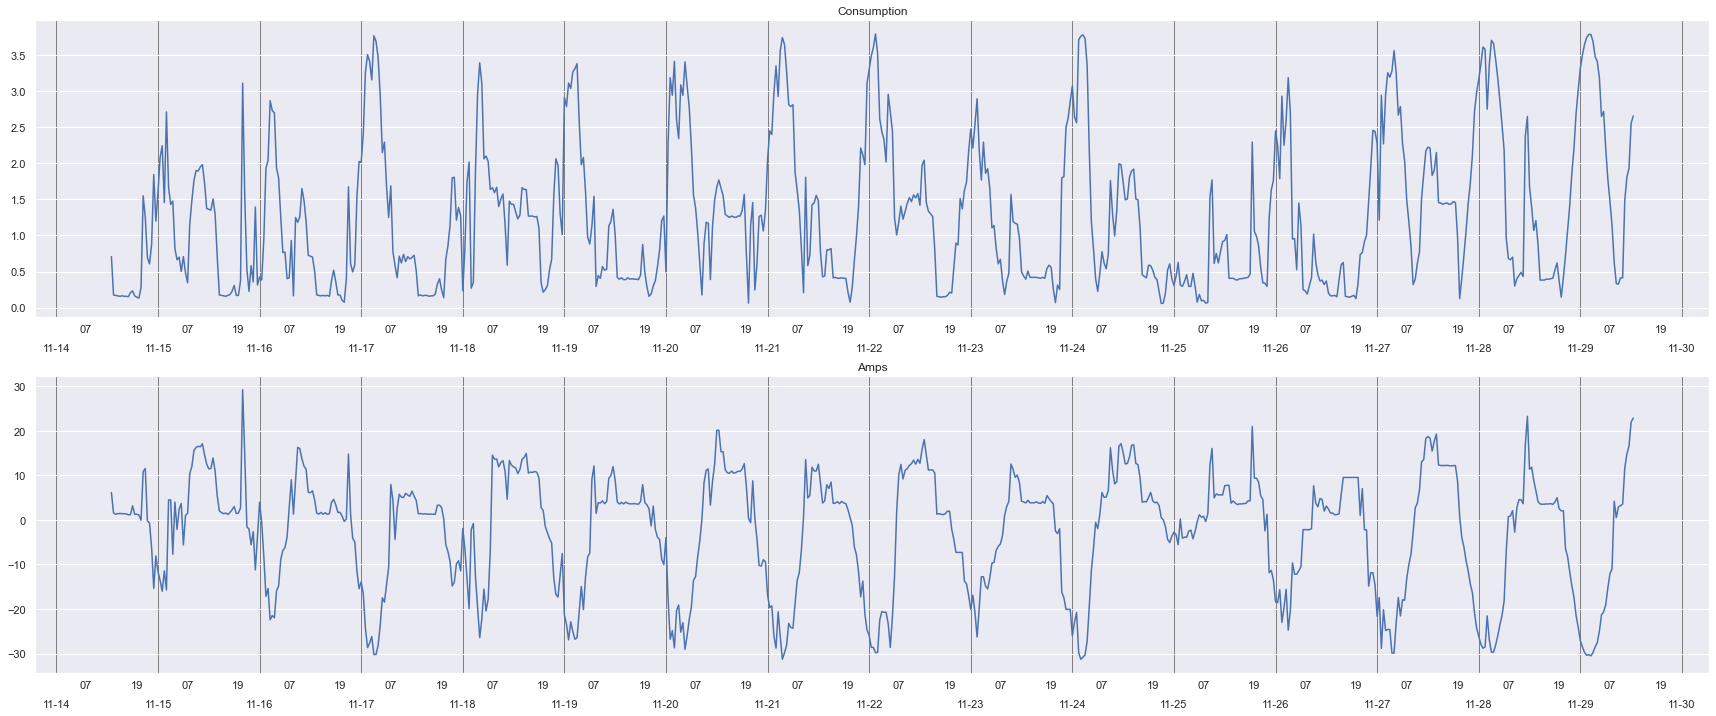

In [24]:
plot_consumption_amps(meters_with_ev[10])

     meter        make      model charger          drive_km  has_ev
11  161806  Mitsubishi  Outlander     Yes  10,000 to 15,000       1


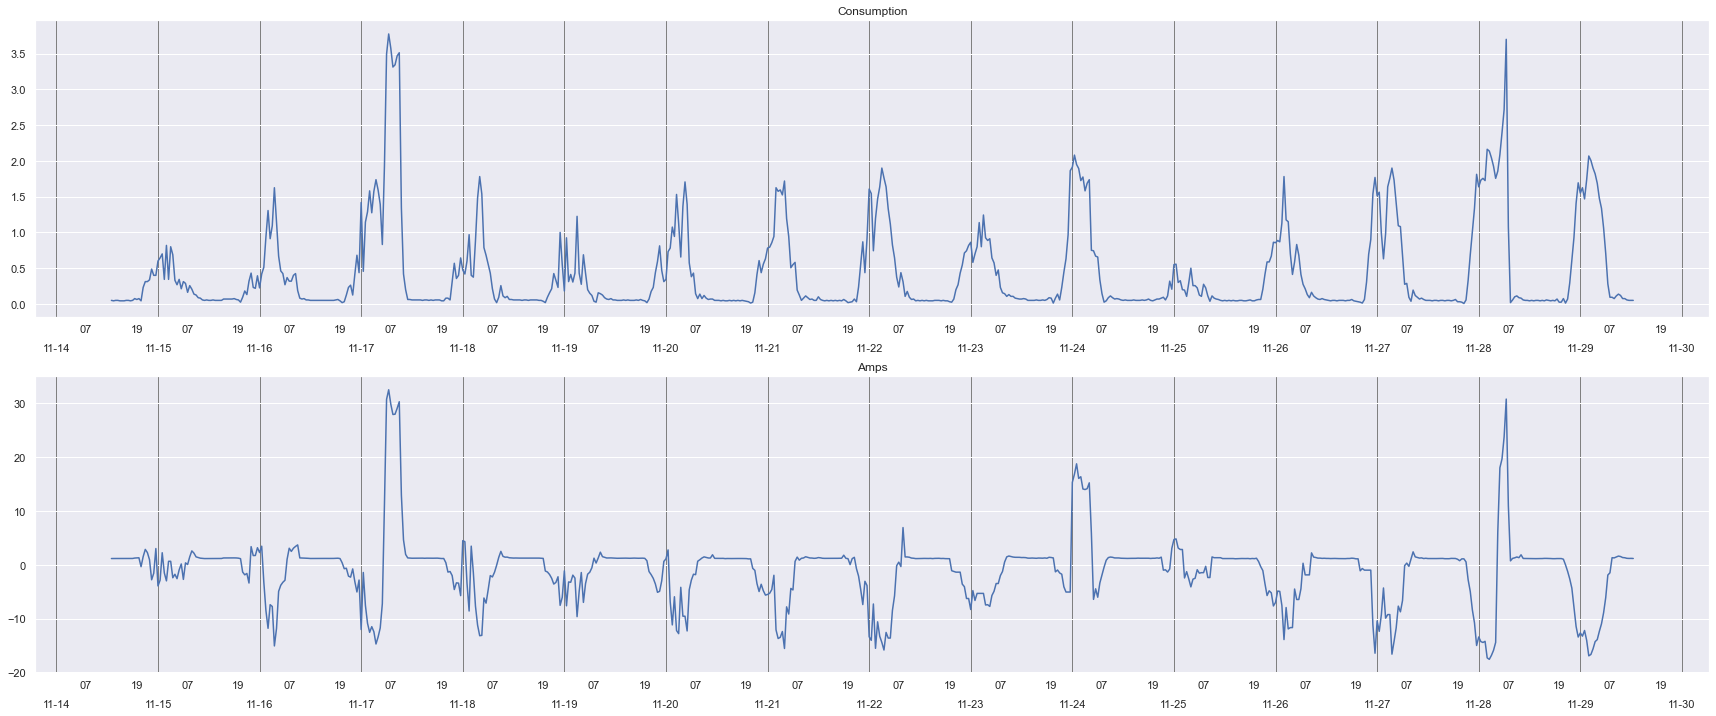

In [25]:
plot_consumption_amps(meters_with_ev[11])

     meter   make    model charger             drive_km  has_ev
12  172232  Tesla  Model 3      No  Greater than 20,000       1


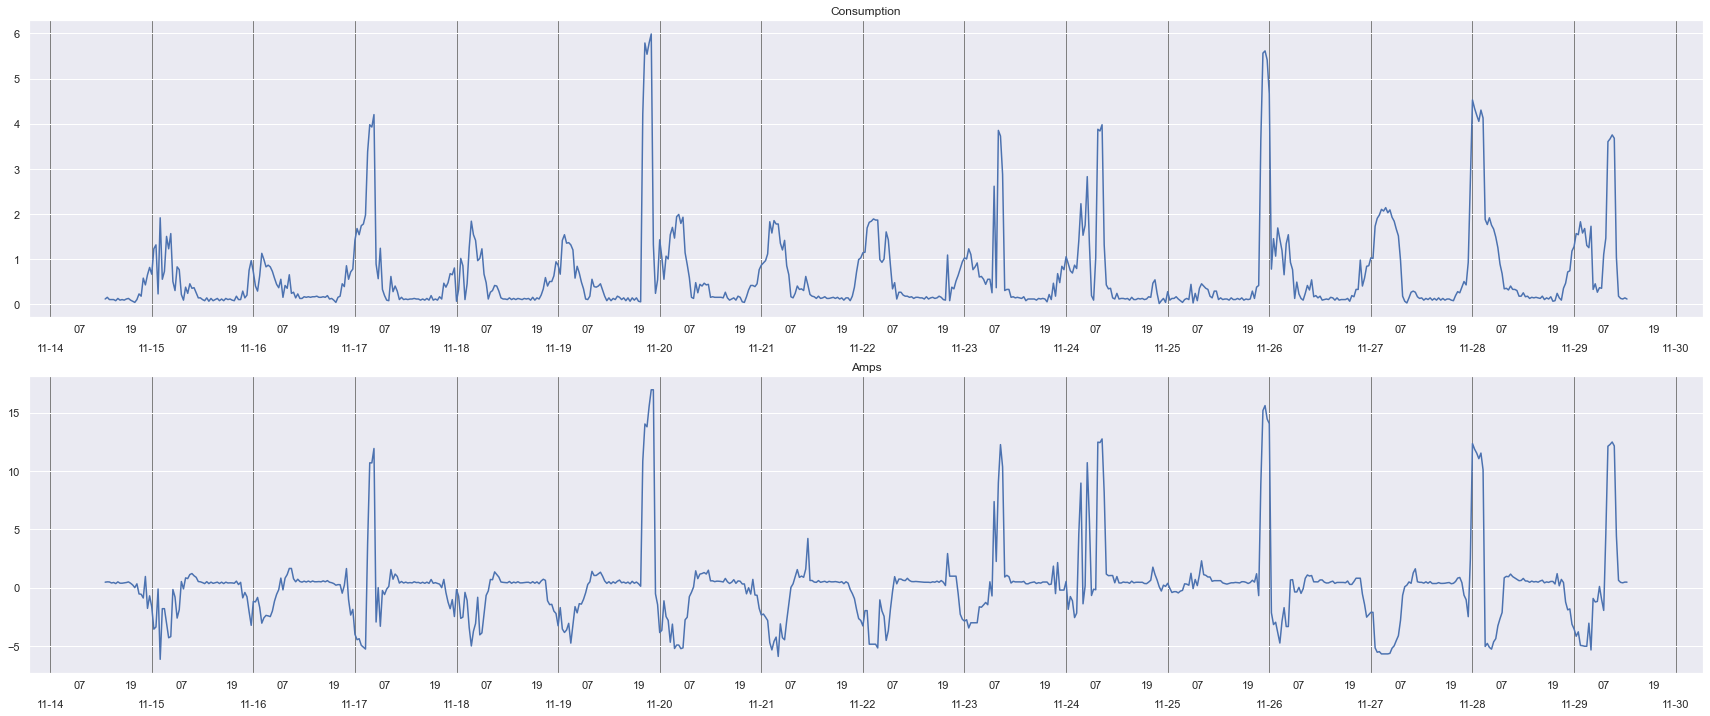

In [26]:
plot_consumption_amps(meters_with_ev[12])

     meter   make    model charger         drive_km  has_ev
13  173927  Tesla  Model S     Yes  5,000 to 10,000       1


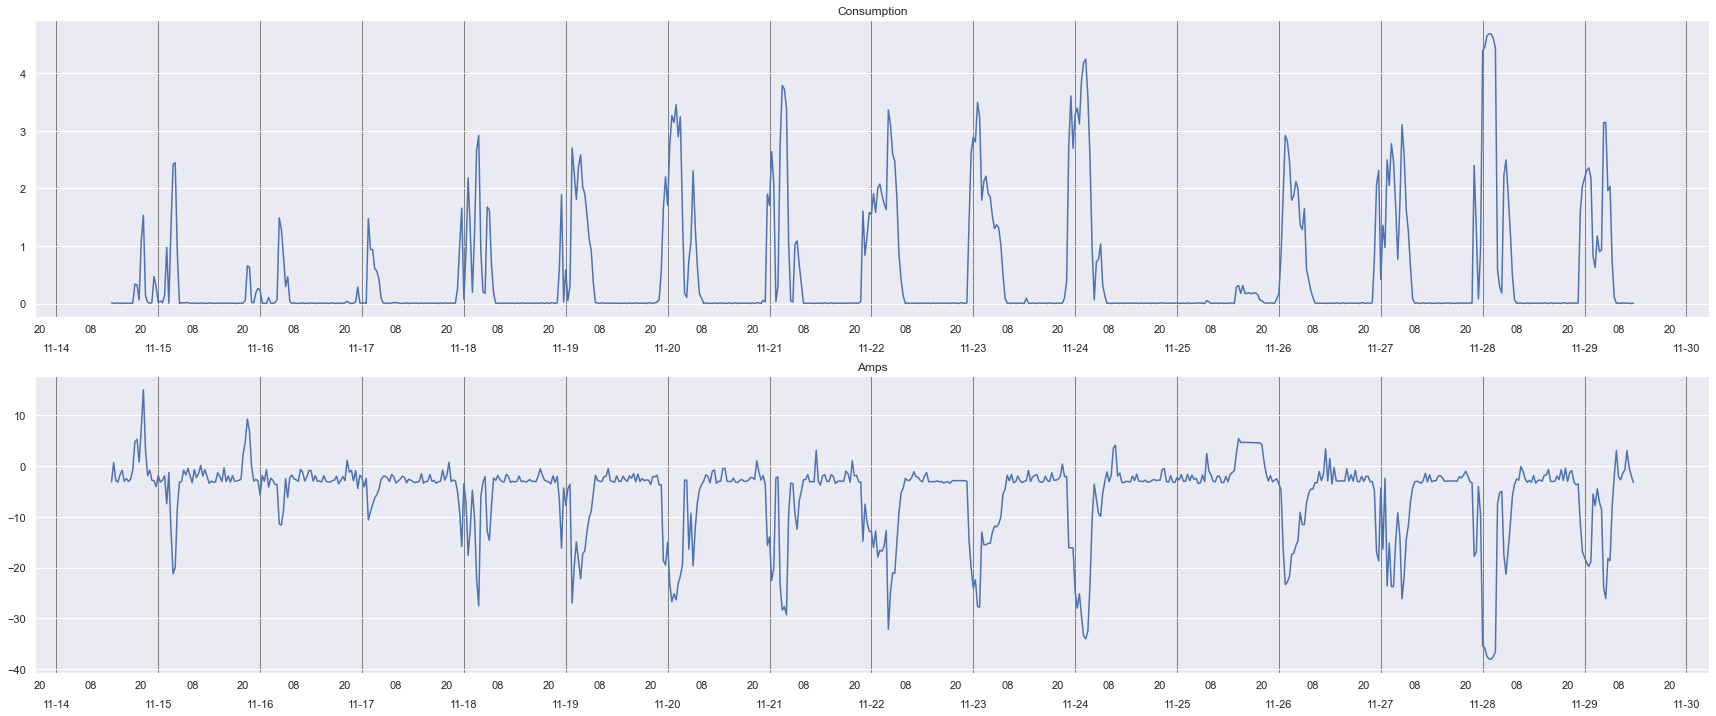

In [27]:
plot_consumption_amps(meters_with_ev[13])

     meter   make    model charger             drive_km  has_ev
14  183009  Tesla  Model 3      No  Greater than 20,000       1


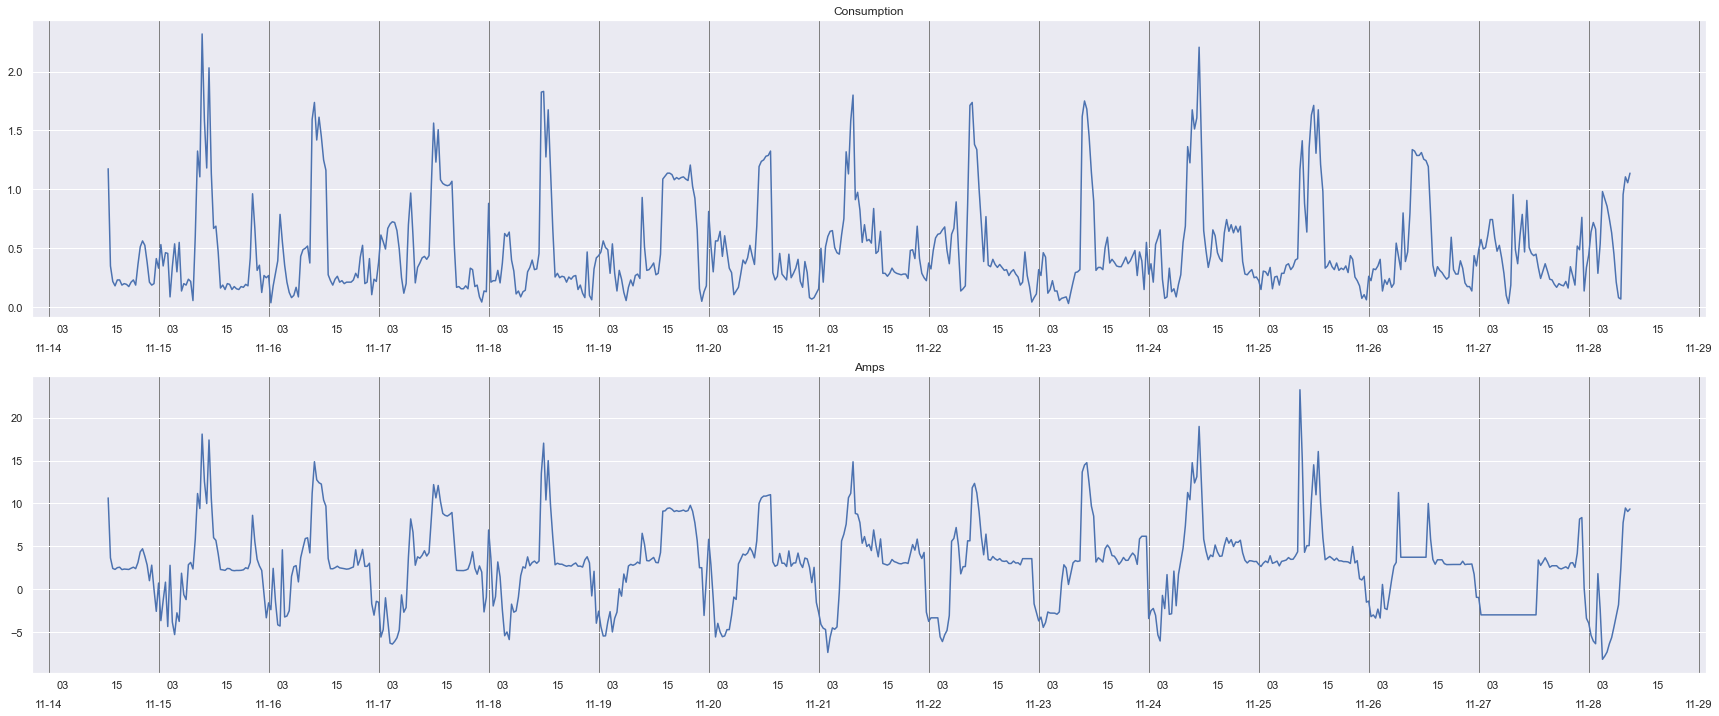

In [28]:
plot_consumption_amps(meters_with_ev[14])

     meter    make    model charger          drive_km  has_ev
15  184799  Tesla   Model 3      No  10,000 to 15,000       1


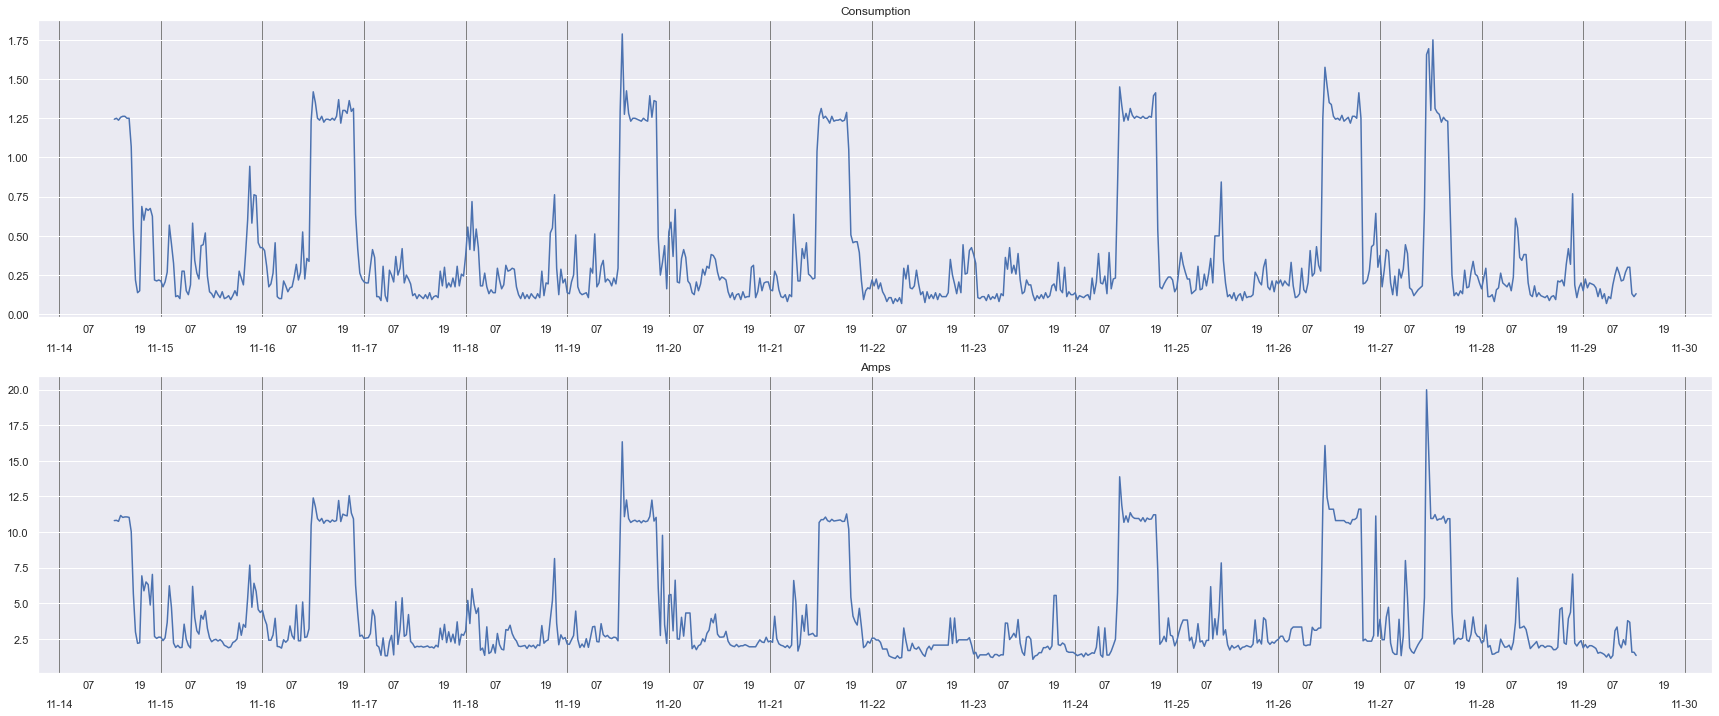

In [29]:
plot_consumption_amps(meters_with_ev[15])


<h3> No EV meters for same period as above </h3>

meter has no EV


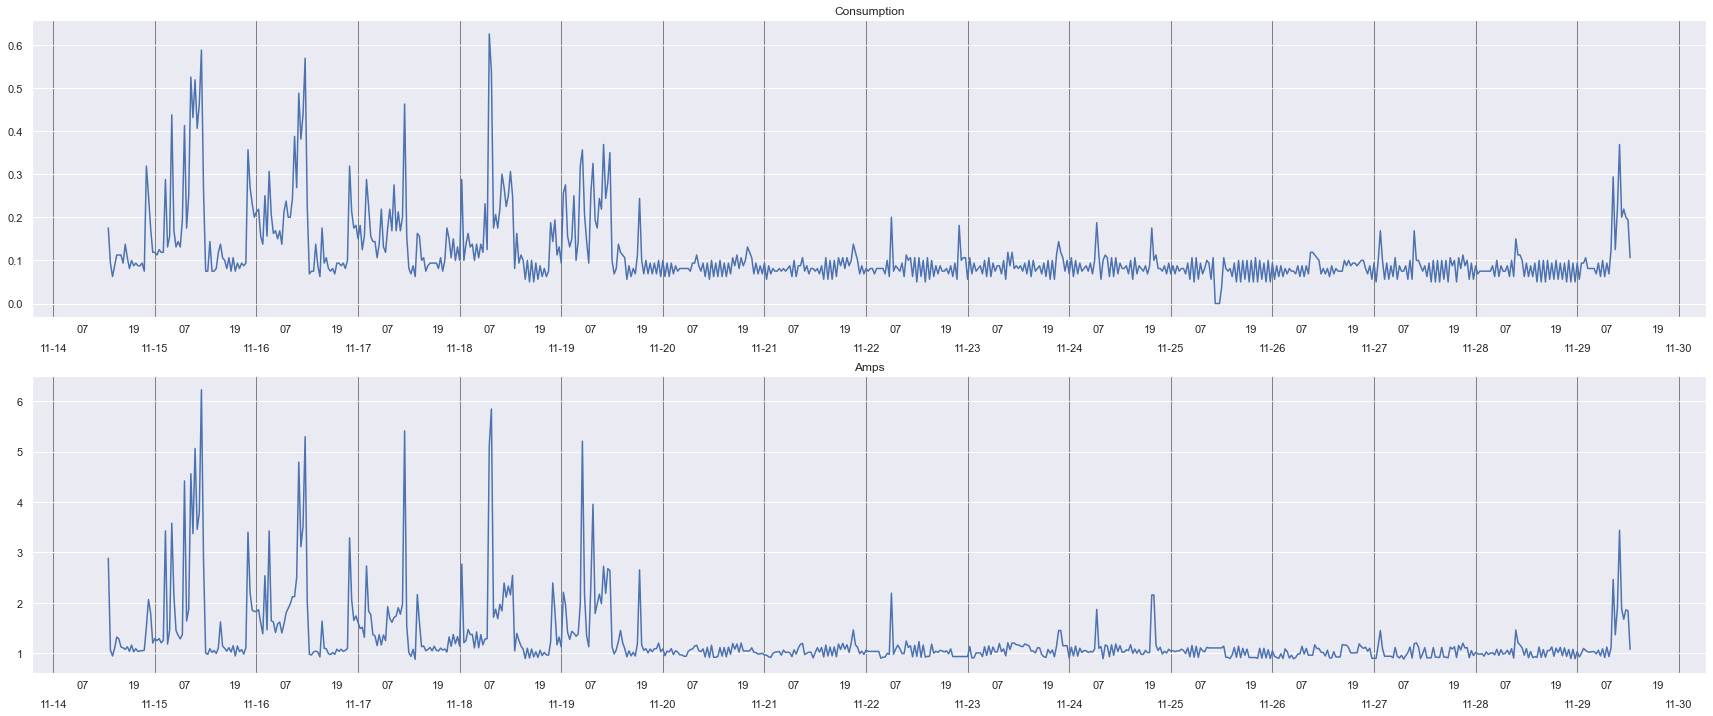

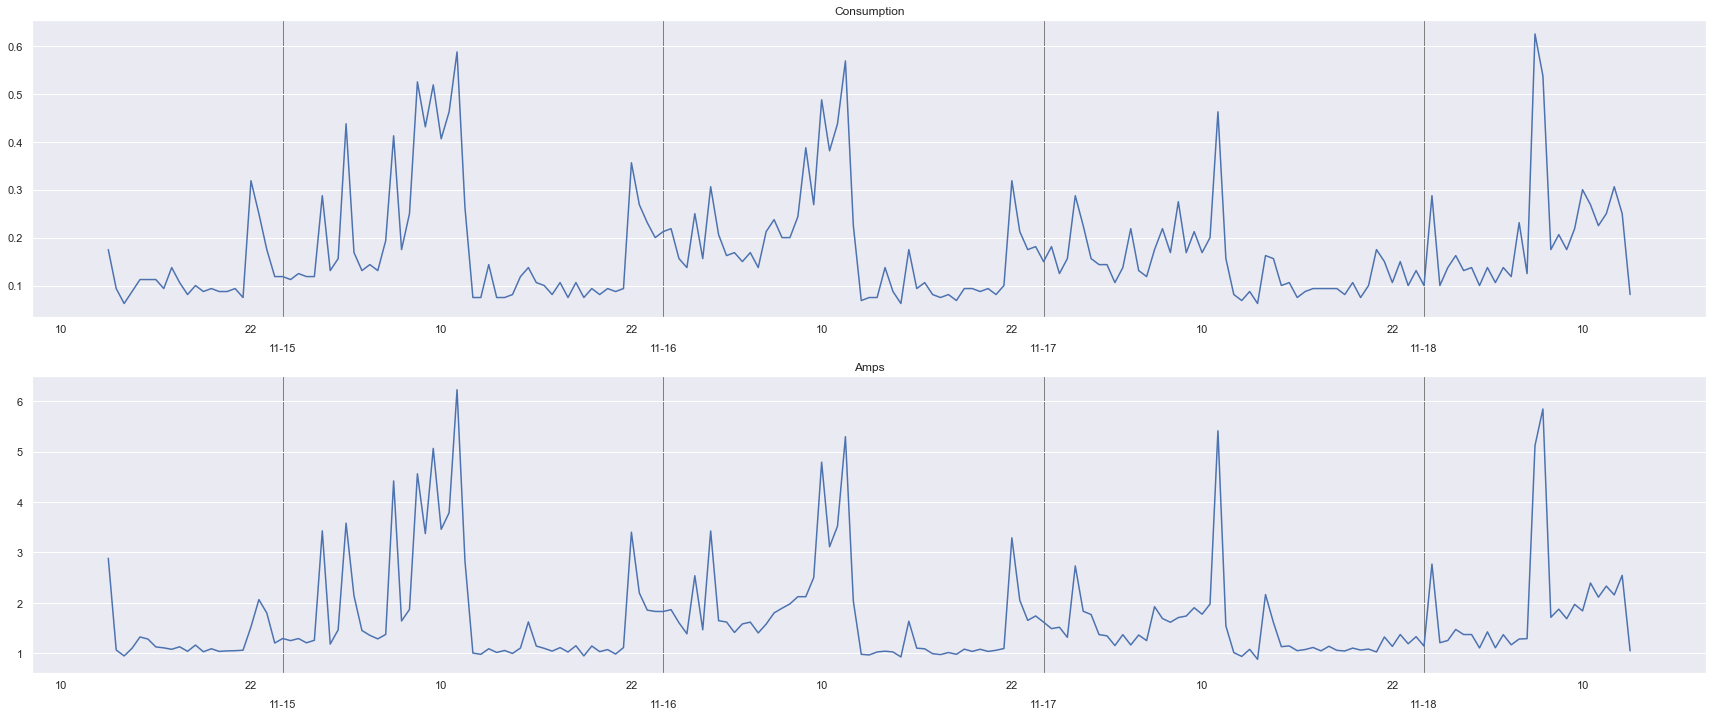

In [30]:
plot_consumption_amps(meters_with_no_ev[0])
plot_consumption_amps(meters_with_no_ev[0], start='2021-11-15', end='2021-11-19', verbose=False)

meter has no EV


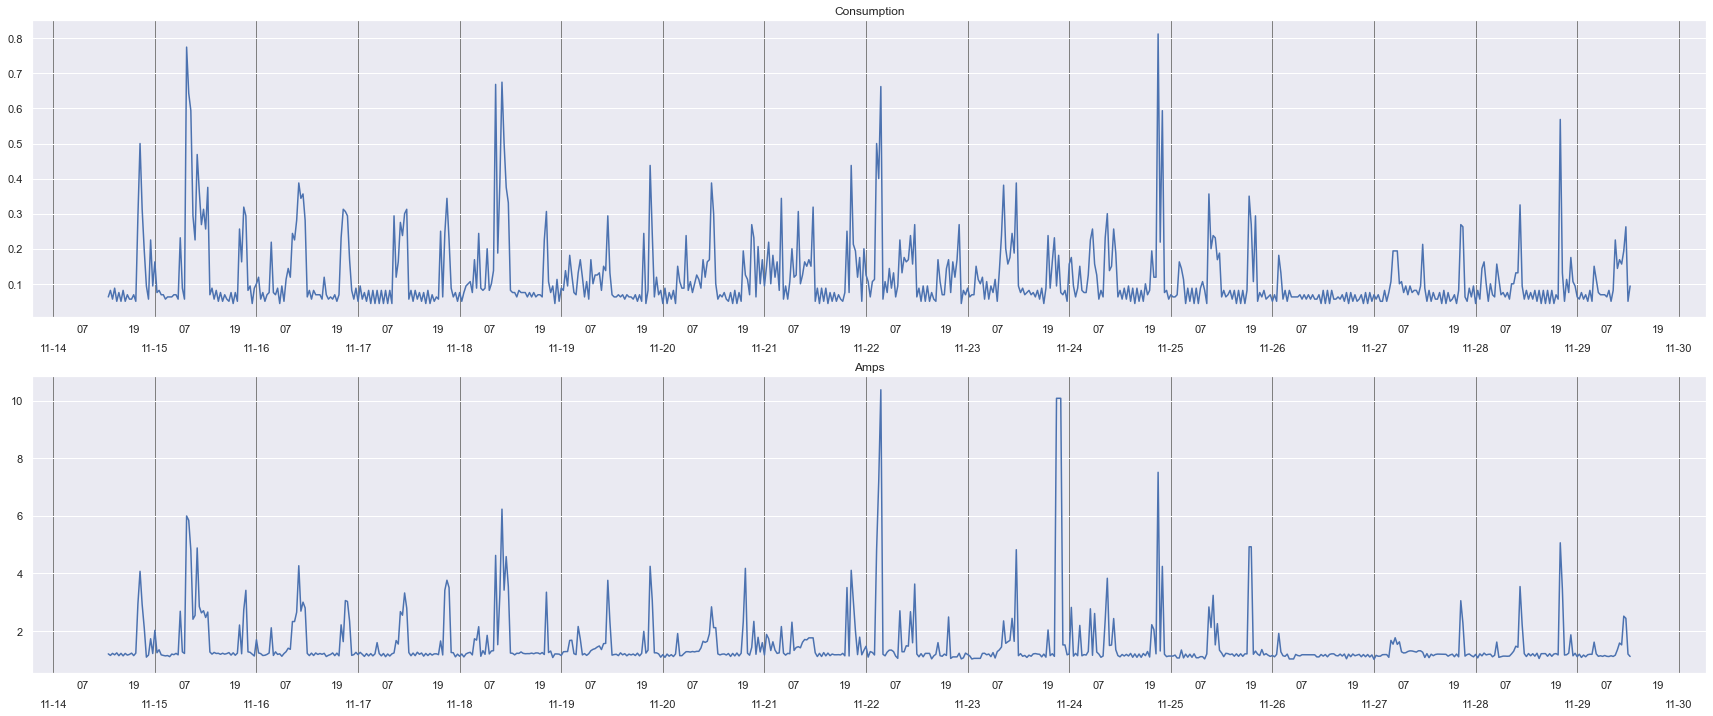

In [31]:
plot_consumption_amps(meters_with_no_ev[1])

meter has no EV


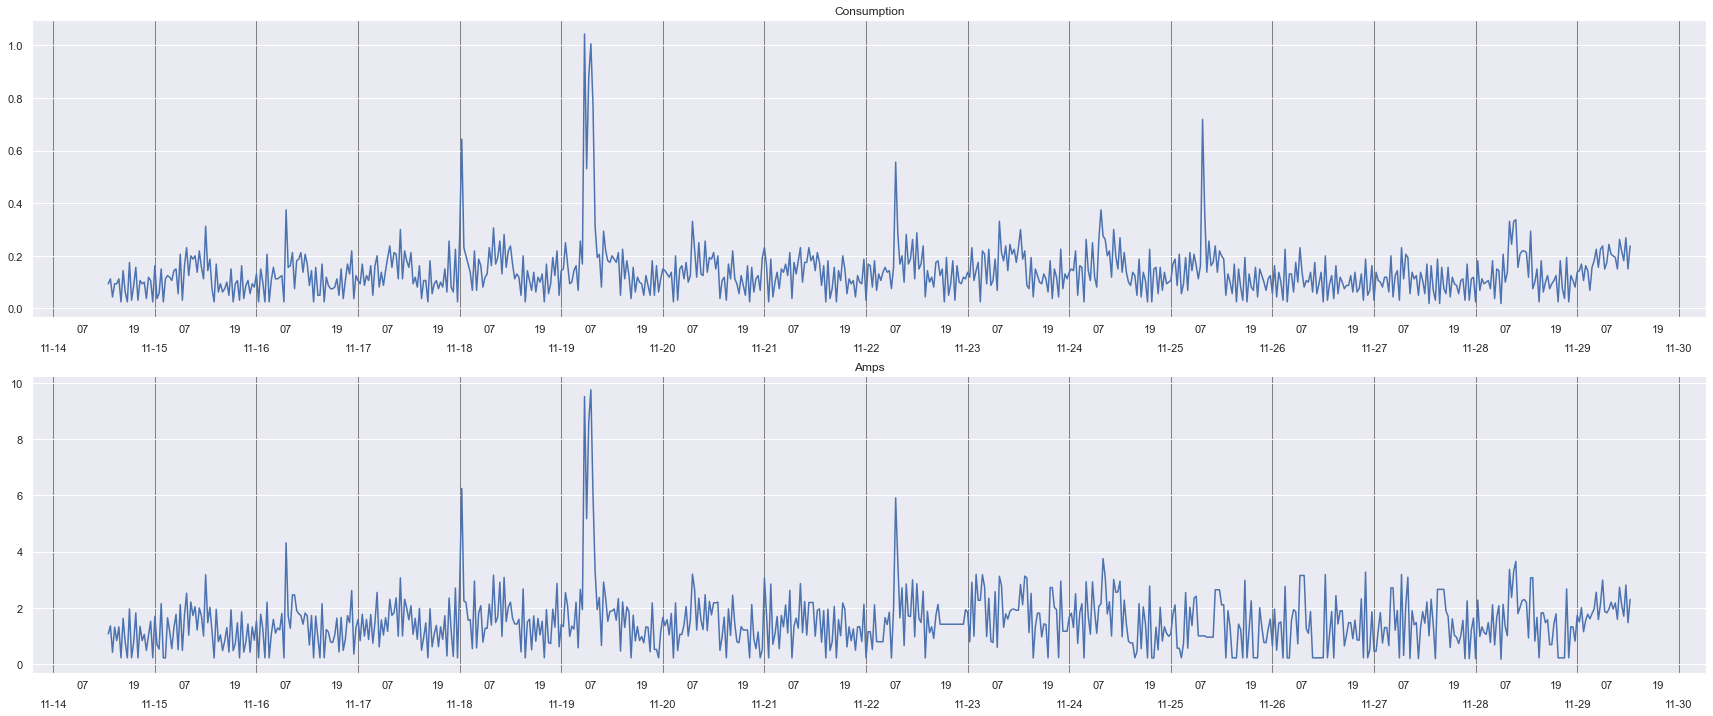

In [32]:
plot_consumption_amps(meters_with_no_ev[2])

meter has no EV


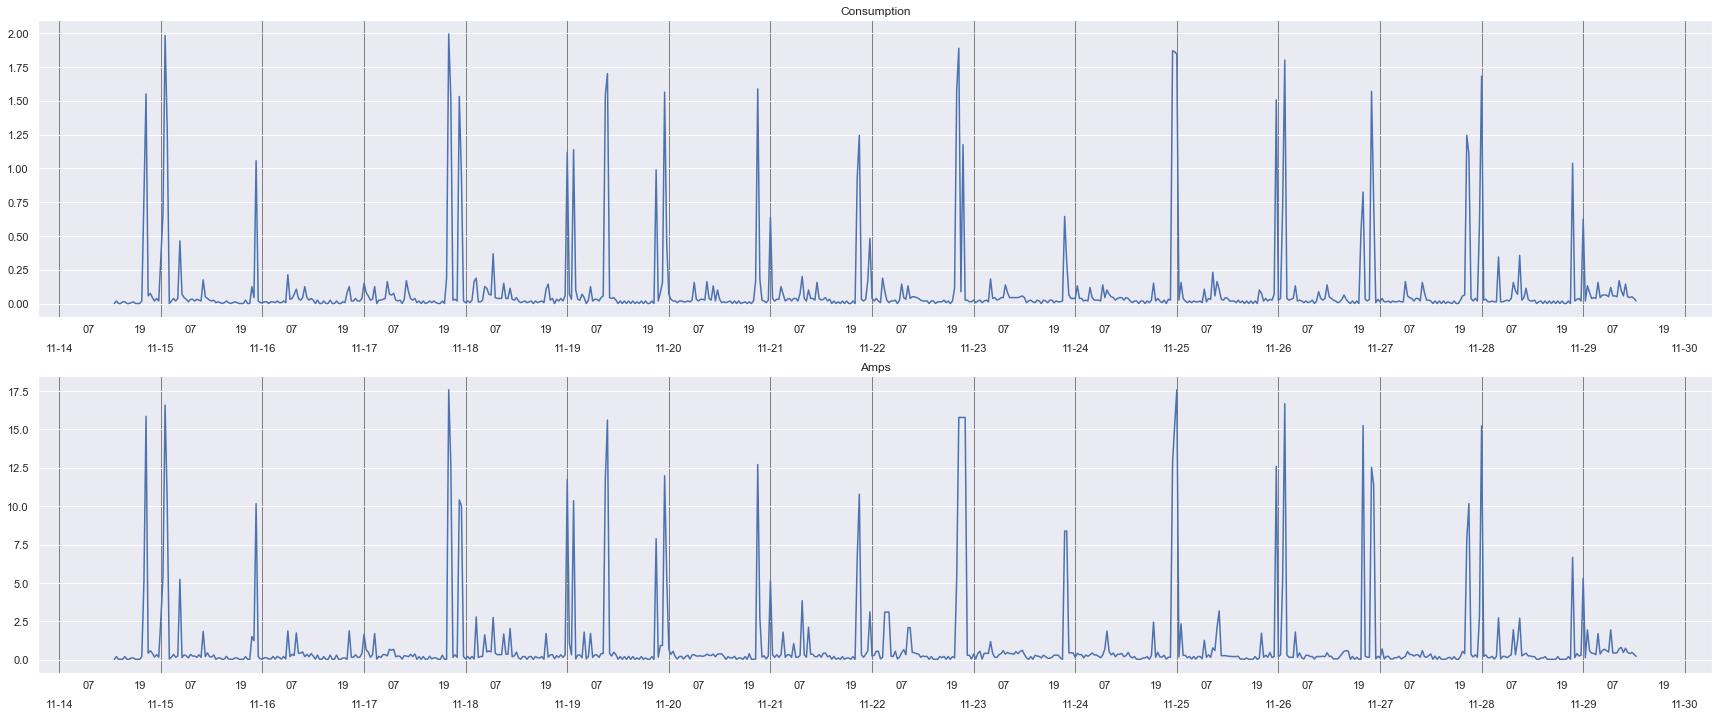

In [33]:
plot_consumption_amps(meters_with_no_ev[3])

meter has no EV


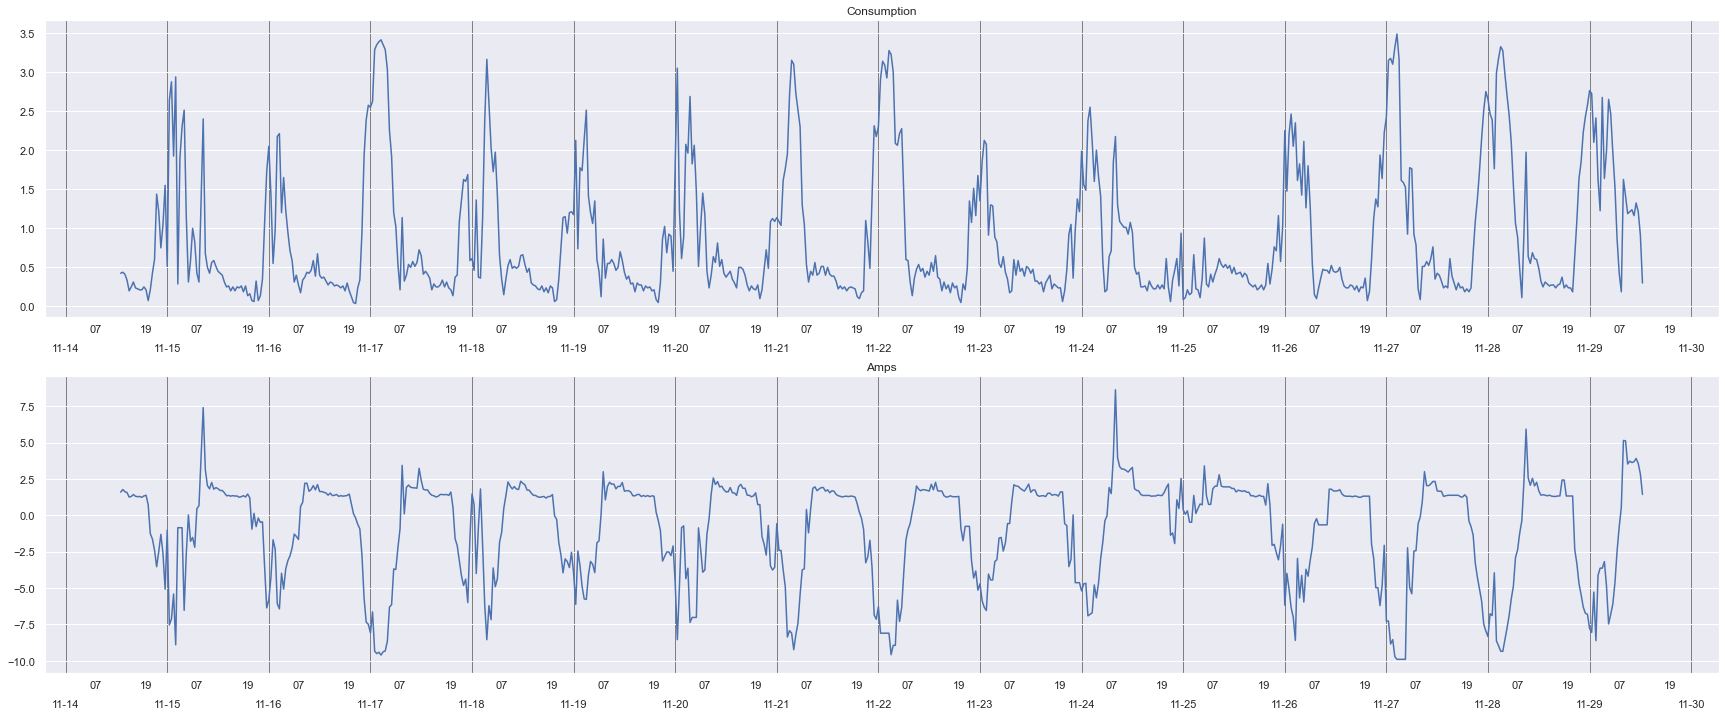

In [34]:
plot_consumption_amps(meters_with_no_ev[4])

meter has no EV


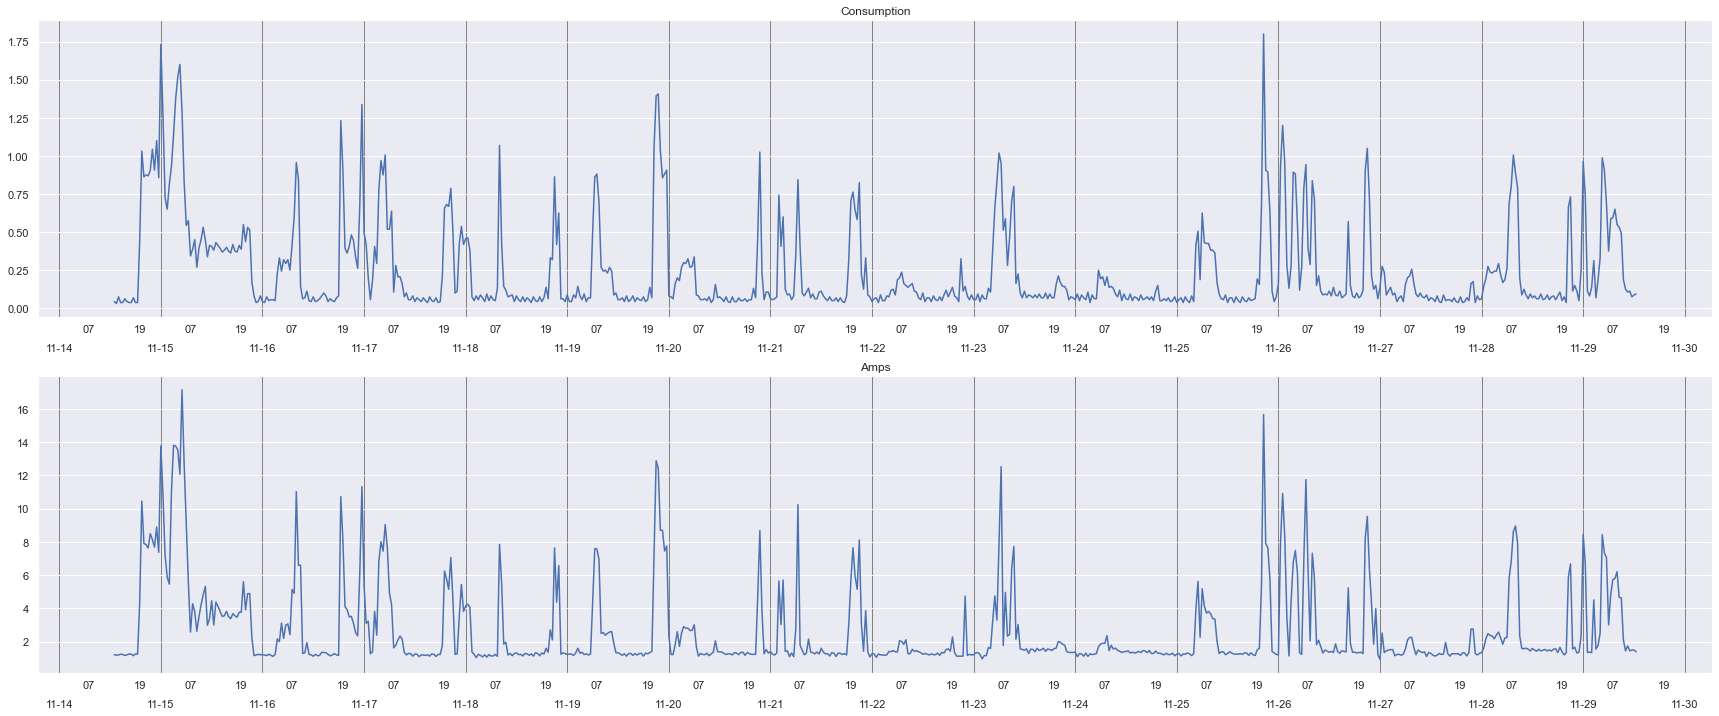

In [35]:
plot_consumption_amps(meters_with_no_ev[5])

meter has no EV


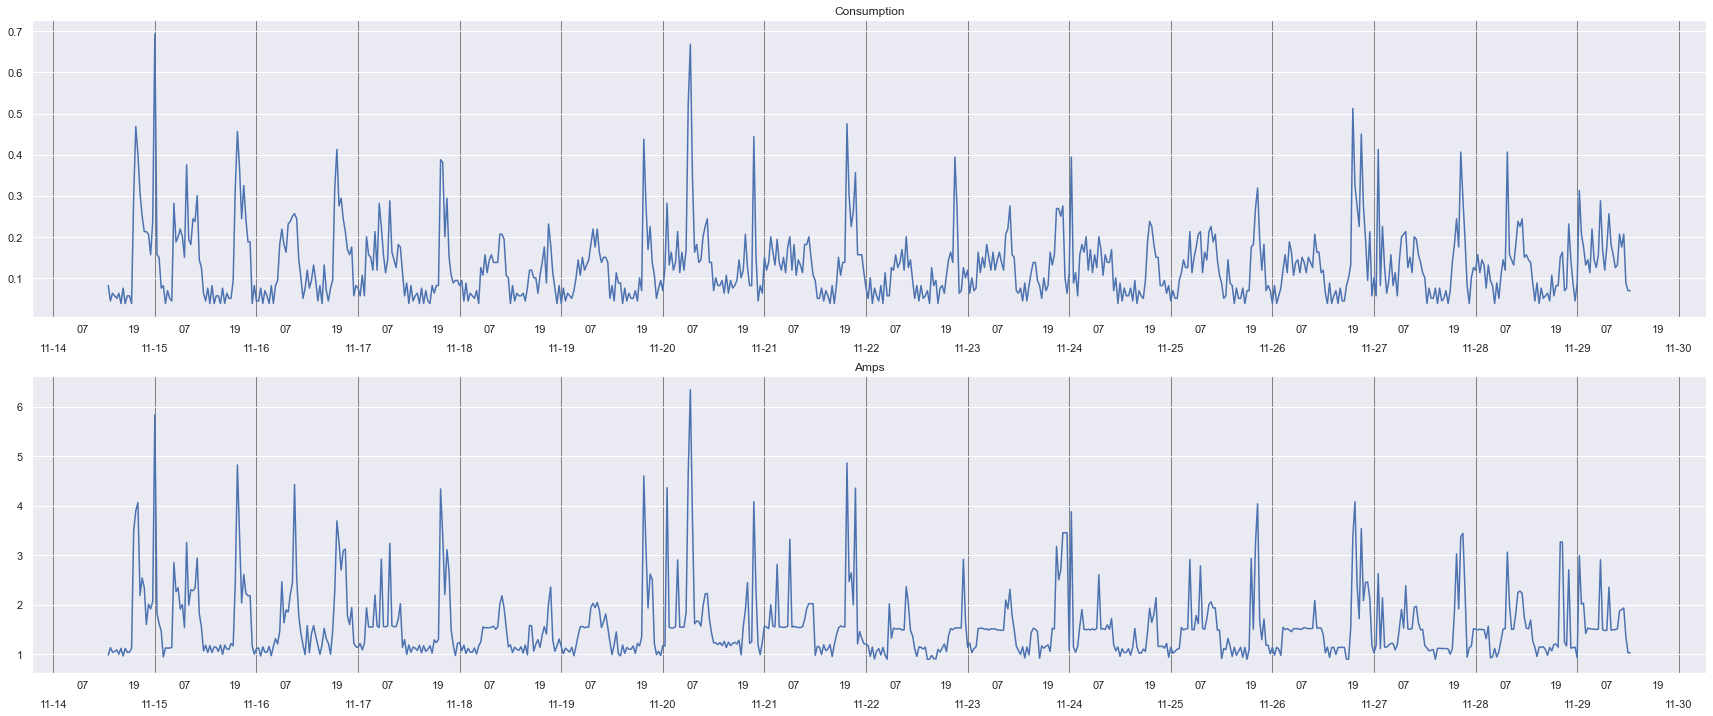

In [36]:

plot_consumption_amps(meters_with_no_ev[7])

meter has no EV


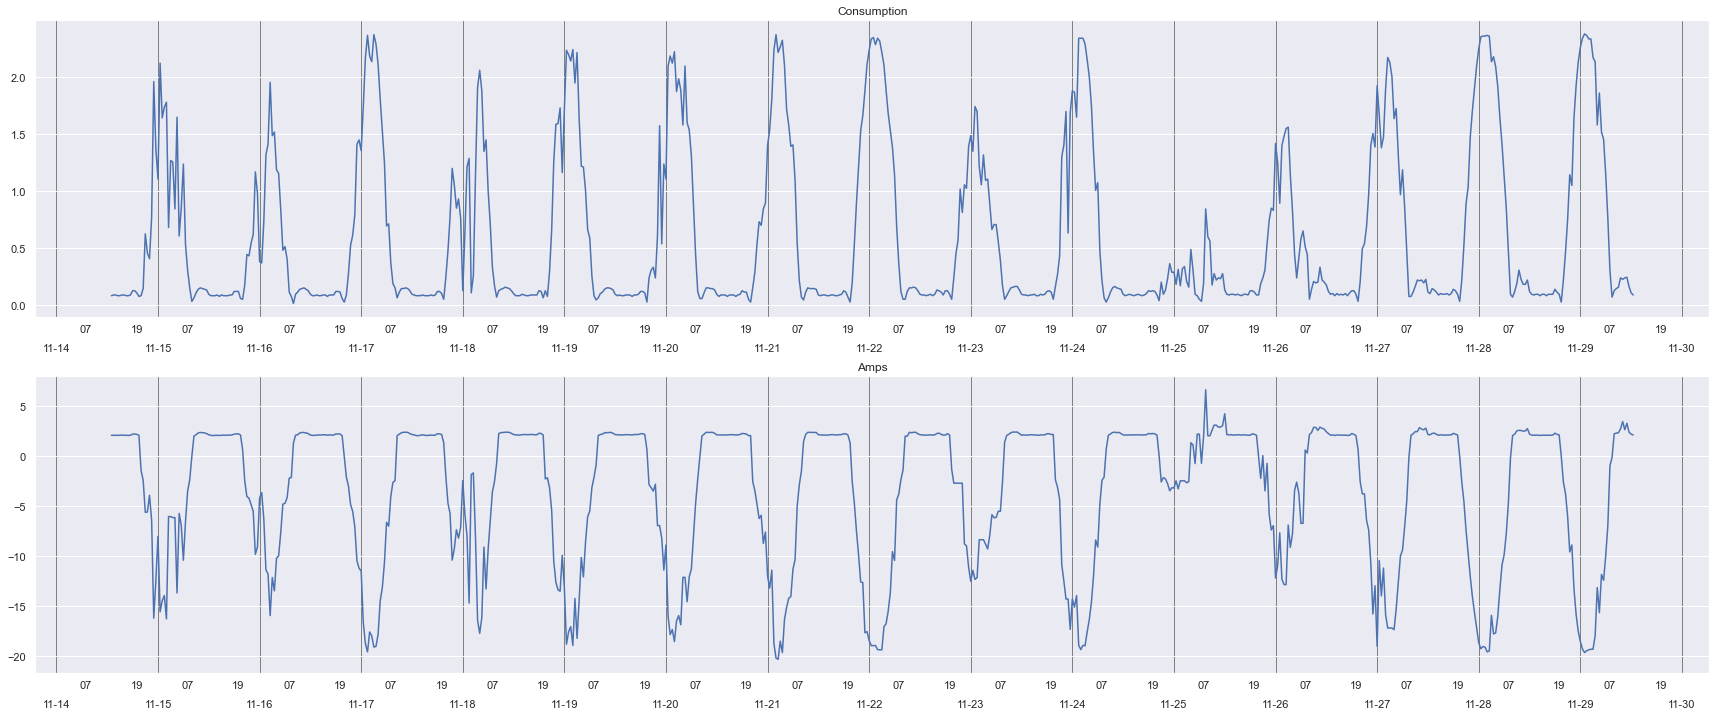

In [37]:
plot_consumption_amps(meters_with_no_ev[8])

meter has no EV


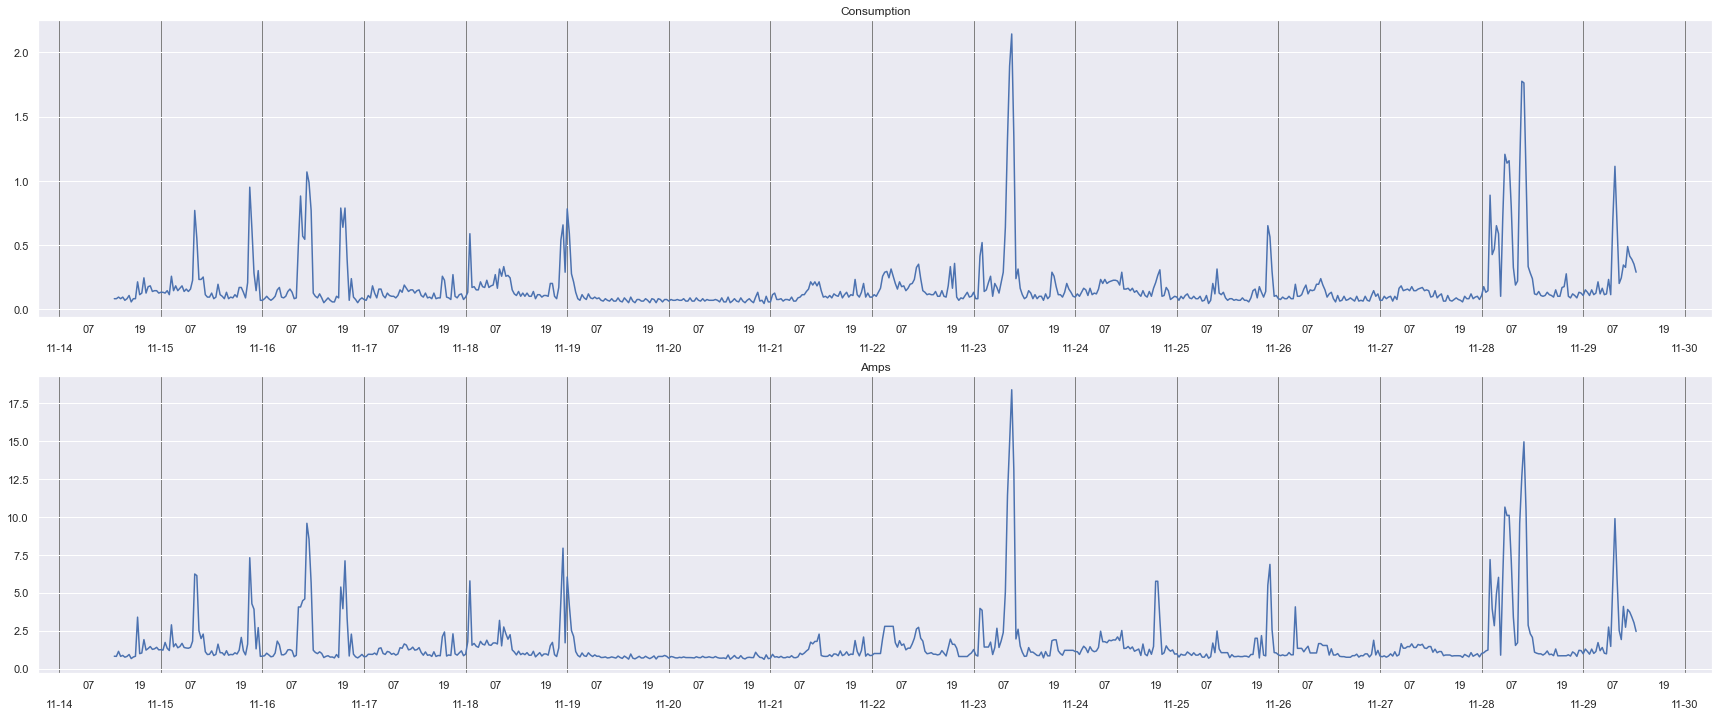

In [38]:
plot_consumption_amps(meters_with_no_ev[9])


meter has no EV


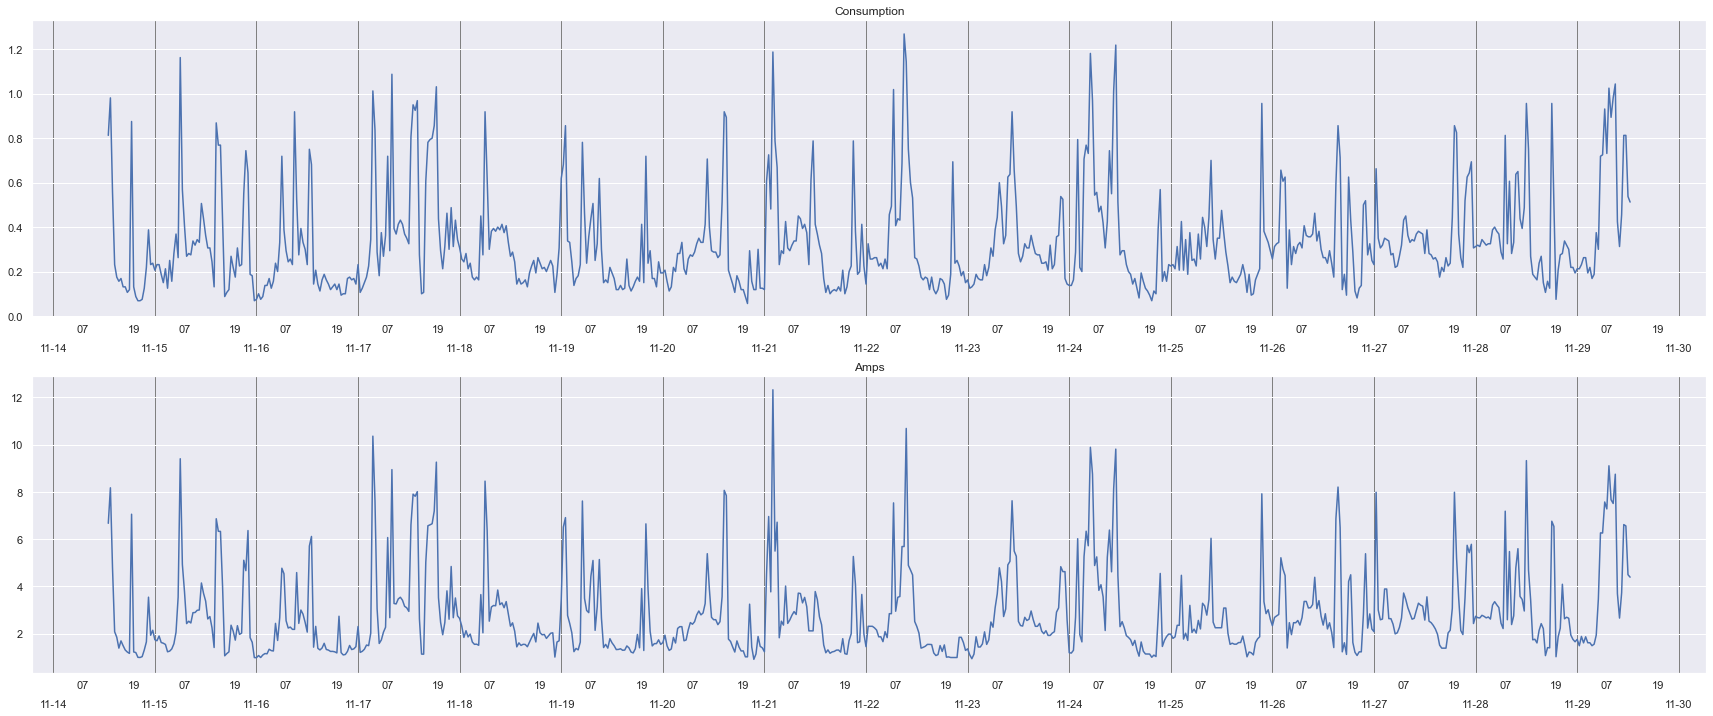

In [39]:
plot_consumption_amps(meters_with_no_ev[10])

meter has no EV


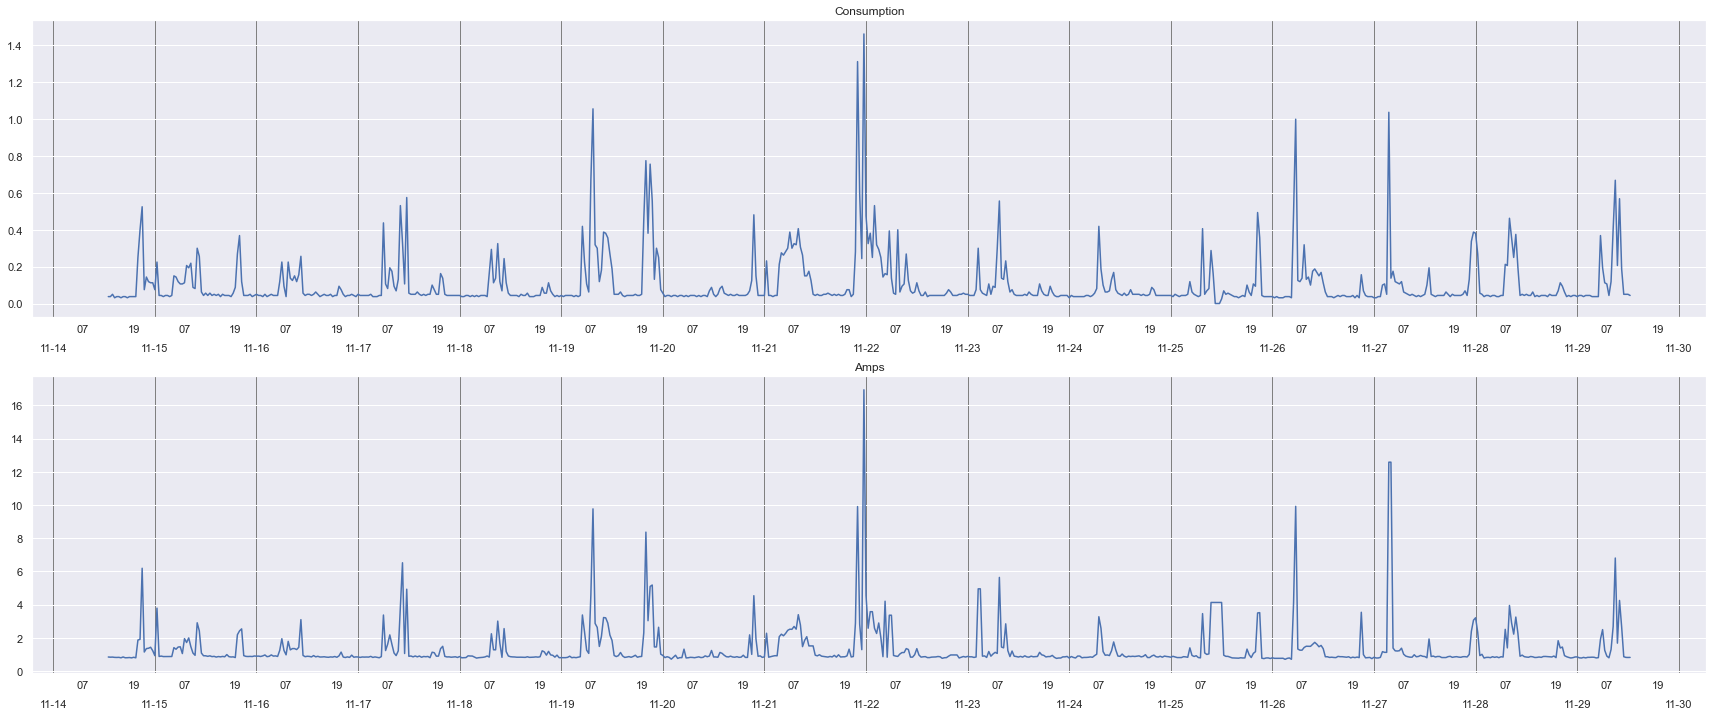

In [40]:
plot_consumption_amps(meters_with_no_ev[11])

meter has no EV


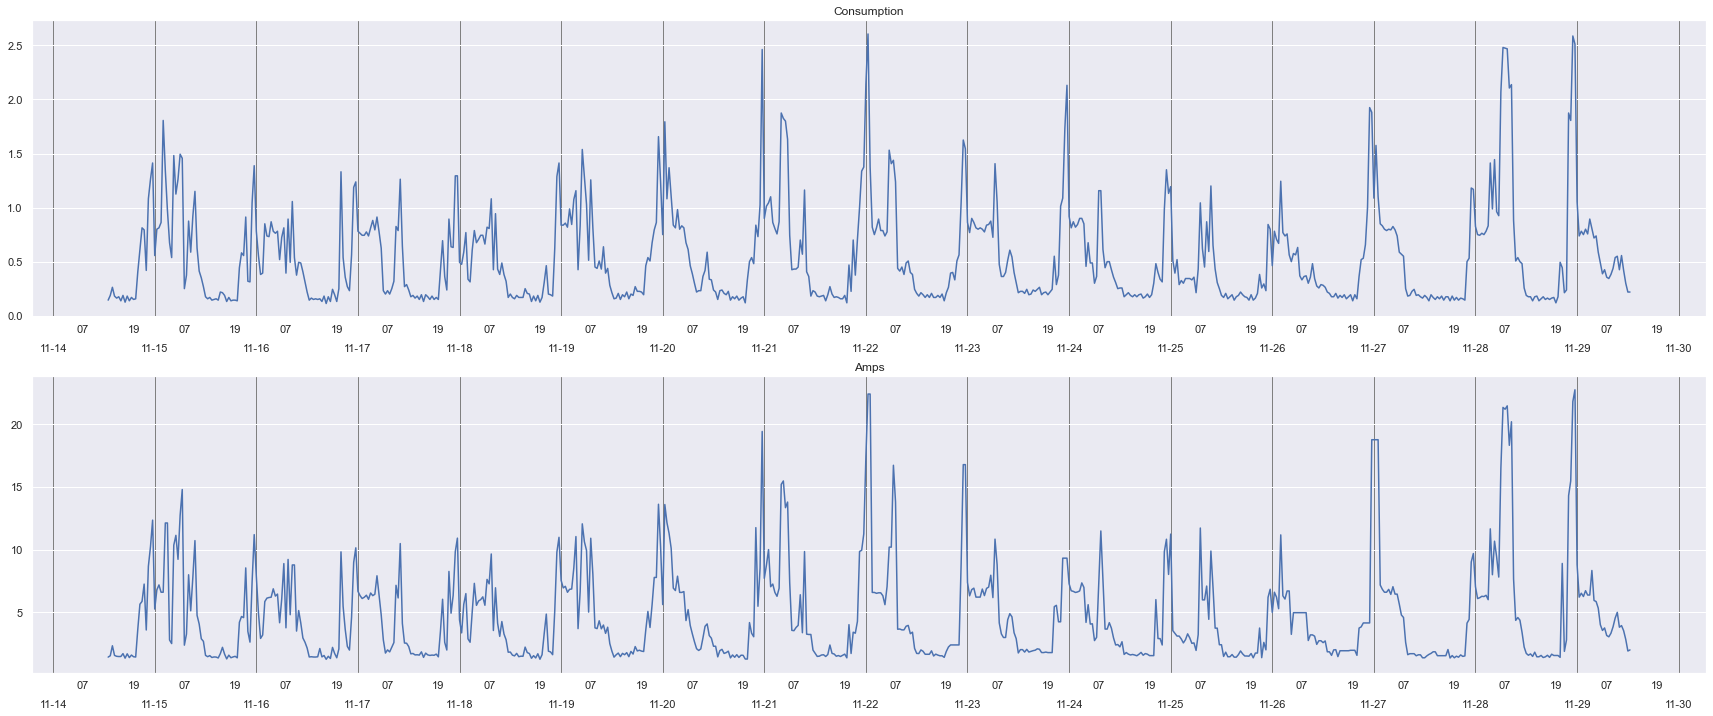

In [41]:
plot_consumption_amps(meters_with_no_ev[12])

meter has no EV
meter has no EV


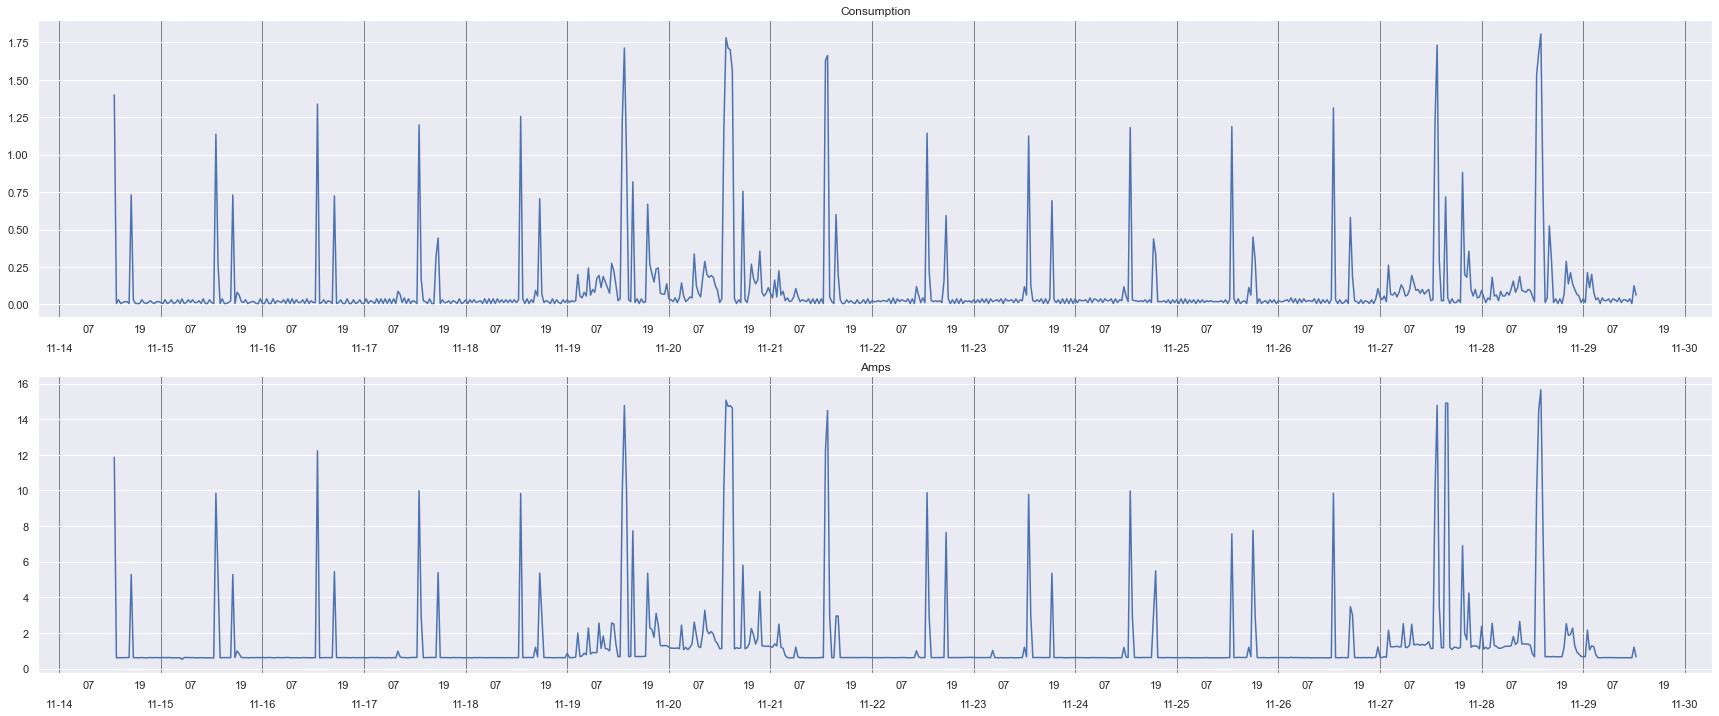

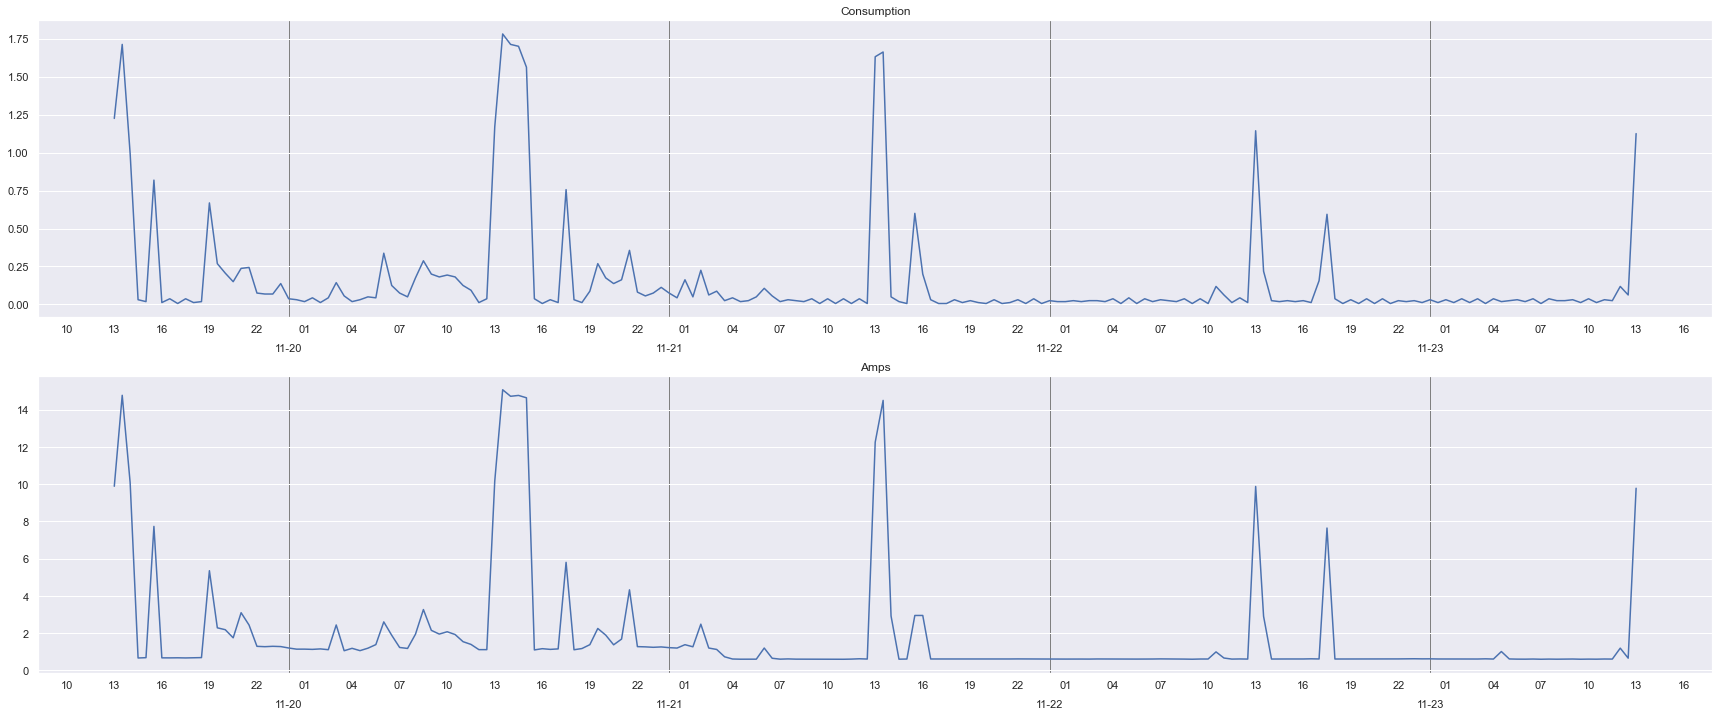

In [42]:
plot_consumption_amps(meters_with_no_ev[13])
plot_consumption_amps(meters_with_no_ev[13], start='2021-11-20', end='2021-11-24', hours_interval=3)

meter has no EV


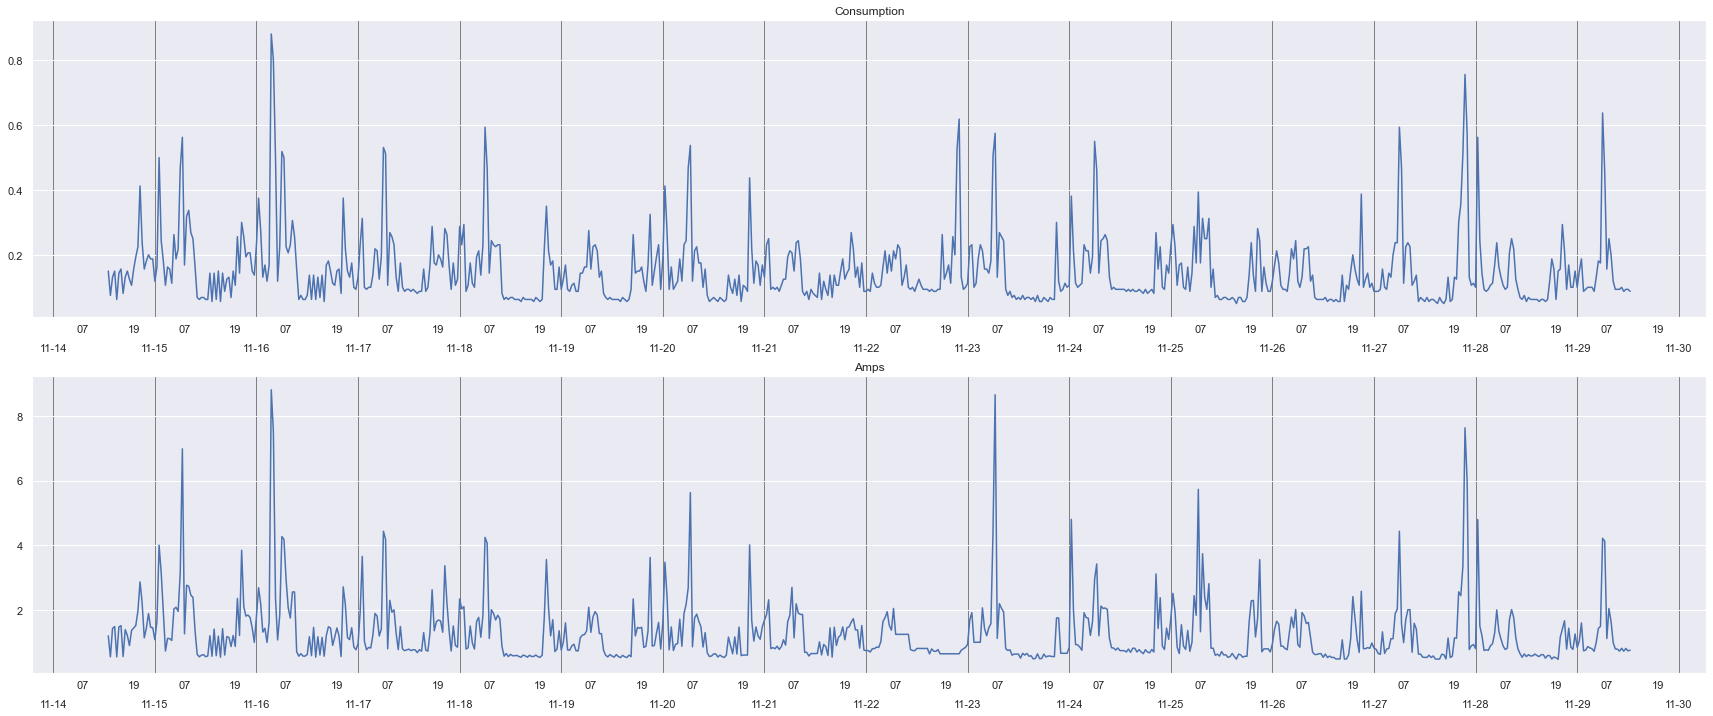

In [43]:
plot_consumption_amps(meters_with_no_ev[14])

meter has no EV


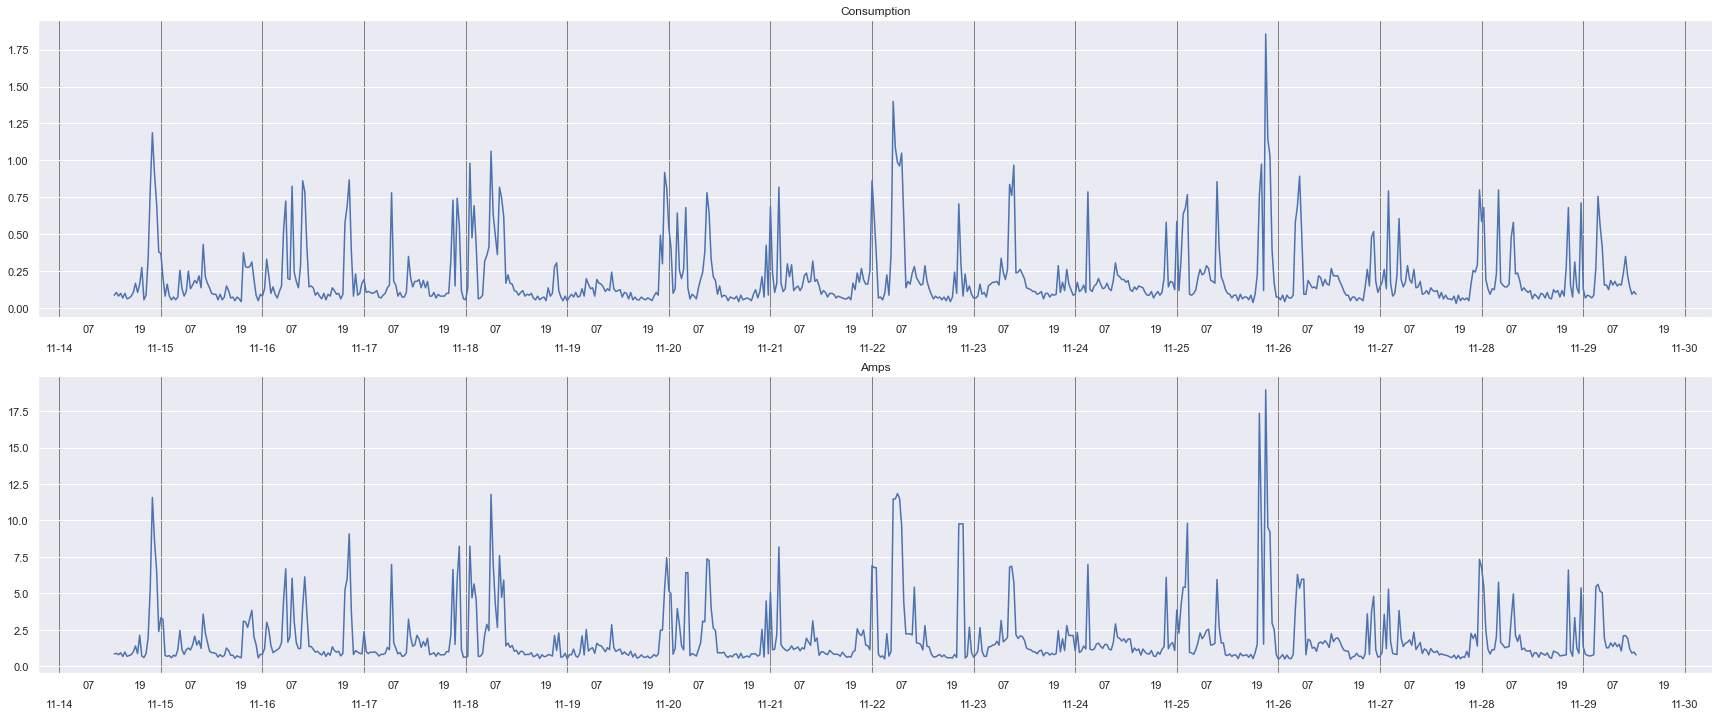

In [44]:
plot_consumption_amps(meters_with_no_ev[15])

<a id='Modelling'></a>

# Feature engineering

<style>
    td {
        font-size: 25%
    }
</style>
From graphical analysis, a common pattern for charging EV is current and consumption increasing and persist at a high level. Therefore, we use these variables to capture this pattren:<br>
    - The length of the longest cycle of "high" consumption(current) within each week
        "high" could be different criteria however, we found the 75 quantile is a plausible choice<br> 
    - The same as above but instead of length of the cycle, we count the number of times, a meter shows "high" 
    consumption(current)<br>
    - difference in consumption(current) over time 
    - Calculating average,  standard deviation and coefficient of variation of these features (weekly)


In [45]:
# helper function
def maxLenSeqAboveNumber(arr, number):
    """return the length of longest subarray with consecutive elements above number"""
    longest,curr=0,0
    for x in arr:
        if x > number:
            curr+=1
        else:
            curr=0
        if curr>longest:longest=curr
    return longest


In [46]:
def longest_cycle(col):
    """return the longest cycle of high consumption(current) in a week """
    return maxLenSeqAboveNumber(col, col.quantile(0.75))

def times_above_threshold(col):
    return np.sum(np.where(
        col > col.quantile(0.75), 1, 0
    ))

In [48]:
# change in consumption (current) over time
for col in ['consumption', 'amps']:
    fulldata[f'diff_{col}'] = np.abs(fulldata[f'{col}'].diff(1))

In [50]:
# aggregating all features by week
df_analysis = fulldata.copy().set_index(['meter', 'time'])
df_analysis = df_analysis.reset_index(level='meter').groupby(['meter']).resample('W').aggregate({
    'consumption': ['mean', 'std', longest_cycle, times_above_threshold],
    'amps': ['mean', 'std', longest_cycle, times_above_threshold],
    'diff_consumption': 'std',
    'diff_amps': 'std',
    'abs_power_factor': 'mean',
})

# caculating coefficient of variance (another probable feature)
for col in ['consumption', 'amps']:
    df_analysis[(col, 'coeff_var')] = df_analysis[(col, 'std')] / df_analysis[(col, 'mean')]

# fixing column names after aggregating
df_analysis = df_analysis.unstack(level='time')
df_analysis.columns = ['_'.join(map(lambda x: str(x), name)).split(' ')[0] for name in df_analysis.columns.to_flat_index()]
df_analysis.head()

# # has_ev will be dropped by above aggregation, we add it back
df_analysis = pd.merge(left=df_analysis, right=meters_with_ev_df, on='meter', how='outer')
df_analysis['has_ev'].fillna(0, inplace=True)
df_analysis.head()

# dropping columns not needed anymore for analysis
df_analysis.drop(['make', 'model', 'charger', 'drive_km'], axis=1,  inplace=True)

In [58]:
# a backup of the full data for analysis 
# df_analysis.to_csv('df_analysis.csv')
fulldata.to_csv('fulldata.csv')